# Restaurant Inspection MVP Model

# Business Understanding

The goal is to predict the outcome of a restaurant's next inspection based on the data located at the City of Las Vegas Open Data Portal.

In [ ]:
# load library

In [1]:
import pandas as pd
import numpy as np

import folium
from folium.plugins import FastMarkerCluster

import matplotlib.pyplot as plt

import plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import seaborn as sns

from uszipcode import SearchEngine, SimpleZipcode, Zipcode
import math
import re

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import ParameterGrid, StratifiedKFold, KFold
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import f1_score, precision_recall_curve


import xgboost as xgb
from xgboost import XGBClassifier


ModuleNotFoundError: No module named 'folium'

# import data

In [2]:
train_data=pd.read_csv("TRAIN_SET.CSV")

In [1420]:
test_data=pd.read_csv("TEST_SET.CSV")

# Data Understanding

In [210]:
train_data.head()

,RESTAURANT_SERIAL_NUMBER,RESTAURANT_PERMIT_NUMBER,RESTAURANT_NAME,RESTAURANT_LOCATION,RESTAURANT_CATEGORY,ADDRESS,CITY,STATE,ZIP,CURRENT_DEMERITS,...,RECORD_UPDATED,LAT_LONG_RAW,FIRST_VIOLATION,SECOND_VIOLATION,THIRD_VIOLATION,FIRST_VIOLATION_TYPE,SECOND_VIOLATION_TYPE,THIRD_VIOLATION_TYPE,NUMBER_OF_VIOLATIONS,NEXT_INSPECTION_GRADE_C_OR_BELOW
0,DA1117270,PR0004527,SANDS EXPO HALL B2 CONCESSION,SANDS EXPO & CONVENTION CENTER,Snack Bar,201 E Sands Ave,Las Vegas,Nevada,89169-2617,0.0,...,1/6/2015 16:34,"(36.1221442, 115.1652749)",204.0,215.0,302.0,Critical,Major,Imminent Health Hazard,4.0,0.0
1,DA1014948,PR0024221,THAI NOODLES CAFE - RESTAURANT,THAI NOODLES CAFE,Restaurant,6710 W CHEYENNE Ave,Las Vegas,Nevada,89108-4588,3.0,...,2/21/2013 22:26,"(36.218691, 115.242913)",214.0,216.0,229.0,Major,Major,Non-Major,5.0,0.0
2,DA0861994,PR0019017,SANTA FE SPORTS BOOK GRILL,Santa Fe Station Hotel & Casino,Restaurant,4949 N Rancho Dr,Las Vegas,Nevada,89130-3505,8.0,...,4/6/2015 9:00,"(36.2498922, 115.2441383)",202.0,215.0,233.0,Critical,Major,Non-Major,3.0,1.0
3,DA0896719,PR0001343,"Bracken, Walter Elem School Kit","Bracken, Walter Elem School",Elementary School Kitchen,1200 N 27Th St,Las Vegas,Nevada,89101-1517,0.0,...,2/21/2013 22:26,"(36.183669, 115.112355)",214.0,230.0,233.0,Major,Non-Major,Non-Major,3.0,0.0
4,DA1031041,PR0006084,HARD ROCK JOINT EAST SVC BAR FL 1,HARD ROCK HOTEL & CASINO,Bar / Tavern,4455 S Paradise Rd,Las Vegas,Nevada,89169-6574,0.0,...,2/21/2013 22:26,"(36.1100828, 115.1538714)",214.0,230.0,233.0,Major,Non-Major,Non-Major,NaN,0.0


In [211]:
test_data.head()

,RESTAURANT_SERIAL_NUMBER,RESTAURANT_PERMIT_NUMBER,RESTAURANT_NAME,RESTAURANT_LOCATION,RESTAURANT_CATEGORY,ADDRESS,CITY,STATE,ZIP,CURRENT_DEMERITS,...,FIRST_VIOLATION,SECOND_VIOLATION,THIRD_VIOLATION,FIRST_VIOLATION_TYPE,SECOND_VIOLATION_TYPE,THIRD_VIOLATION_TYPE,NUMBER_OF_VIOLATIONS,EMPLOYEE_COUNT,MEDIAN_EMPLOYEE_AGE,MEDIAN_EMPLOYEE_TENURE
0,DA1050454,PR0022396,TE PUB EXHIB KITCHEN,TE PUB @ CRYSTALS,Special Kitchen,3720 S LAS VEGAS,Las Vegas,Nevada,89158,6,...,209,213,217,Critical,Major,Major,5,3.000000,31.141933,3.542119
1,DA0986444,PR0014531,Plaza Hotel Showroom Bar,Plaza Hotel & Casino,Bar / Tavern,1 S Main St,Las Vegas,Nevada,89101-6370,0,...,214,222,227,Major,Major,Non-Major,4,18.598406,26.839893,4.885881
2,DA1284914,PR0014520,Plaza Hotel Race & Sportsbook Bar,Plaza Hotel & Casino,Bar / Tavern,1 S Main St,Overton,Nevada,89101-6370,8,...,211,212,213,Major,Major,Major,6,5.730357,31.202256,1.883055
3,DA1281903,PR0014203,Prommares Thai Food,Prommares Thai Food,Restaurant,6362 W Sahara Ave,Las Vegas,Nevada,89146-3050,0,...,202,206,209,1,Critical,Critical,11,15.075238,36.656000,6.761476
4,DA1004708,PR0017538,ROCCOS NY PIZZA,ROCCOS NY PIZZA,Restaurant,1910 VILLAGE CENTER Cir,Las Vegas,Nevada,89134,9,...,213,214,226,Major,Major,Non-Major,6,14.218813,21.001225,6.601620


In [212]:
# size
train_data.shape

(15673, 28)

In [213]:
test_data.shape

(7505, 27)

In [214]:
# column names
train_data.columns

Index(['RESTAURANT_SERIAL_NUMBER', 'RESTAURANT_PERMIT_NUMBER',
       'RESTAURANT_NAME', 'RESTAURANT_LOCATION', 'RESTAURANT_CATEGORY',
       'ADDRESS', 'CITY', 'STATE', 'ZIP', 'CURRENT_DEMERITS', 'CURRENT_GRADE',
       'EMPLOYEE_COUNT', 'MEDIAN_EMPLOYEE_AGE', 'MEDIAN_EMPLOYEE_TENURE',
       'INSPECTION_TIME', 'INSPECTION_TYPE', 'INSPECTION_DEMERITS',
       'VIOLATIONS_RAW', 'RECORD_UPDATED', 'LAT_LONG_RAW', 'FIRST_VIOLATION',
       'SECOND_VIOLATION', 'THIRD_VIOLATION', 'FIRST_VIOLATION_TYPE',
       'SECOND_VIOLATION_TYPE', 'THIRD_VIOLATION_TYPE', 'NUMBER_OF_VIOLATIONS',
       'NEXT_INSPECTION_GRADE_C_OR_BELOW'],
      dtype='object')

In [215]:
test_data.columns

Index(['RESTAURANT_SERIAL_NUMBER', 'RESTAURANT_PERMIT_NUMBER',
       'RESTAURANT_NAME', 'RESTAURANT_LOCATION', 'RESTAURANT_CATEGORY',
       'ADDRESS', 'CITY', 'STATE', 'ZIP', 'CURRENT_DEMERITS', 'CURRENT_GRADE',
       'INSPECTION_TIME', 'INSPECTION_TYPE', 'INSPECTION_DEMERITS',
       'VIOLATIONS_RAW', 'RECORD_UPDATED', 'LAT_LONG_RAW', 'FIRST_VIOLATION',
       'SECOND_VIOLATION', 'THIRD_VIOLATION', 'FIRST_VIOLATION_TYPE',
       'SECOND_VIOLATION_TYPE', 'THIRD_VIOLATION_TYPE', 'NUMBER_OF_VIOLATIONS',
       'EMPLOYEE_COUNT', 'MEDIAN_EMPLOYEE_AGE', 'MEDIAN_EMPLOYEE_TENURE'],
      dtype='object')

In [216]:
set(train_data.columns.tolist())-set(test_data.columns.tolist())

{'NEXT_INSPECTION_GRADE_C_OR_BELOW'}

train data has 28 variables, test data has 27 variables. The missing variable in the test data is 'NEXT_INSPECTION_GRADE_C_OR_BELOW', this is the target variable.

# Prepare data

## Identity variables 
'RESTAURANT_SERIAL_NUMBER', 'RESTAURANT_PERMIT_NUMBER','RESTAURANT_NAME'

In [217]:
train_data['RESTAURANT_SERIAL_NUMBER'].nunique()

15673

In [218]:
train_data['RESTAURANT_PERMIT_NUMBER'].nunique()

8654

In [219]:
train_data['RESTAURANT_NAME'].nunique()

8322

comments:
These three variables has the identity information of each restaturant, including their name, serial number and permit number. 
'RESTAURANT_SERIAL_NUMBER' is the unique identity number for each obseveration
'RESTAURANT_PERMIT_NUMBER' and 'RESTAURANT_NAME' has only about 8000 unique values, which means some obseveration has the same permit numbers or names. In other word, one restaurant may have multipe records in the data. **This two variables could be used as references to impute missing value in the data.** For example, if one restaurant has missing value in one variable, we could its other record to impute this missing value.


## Location variables

### 'RESTAURANT_LOCATION','ADDRESS',

In [220]:
train_data['RESTAURANT_LOCATION'].nunique()

4963

In [15]:
train_data['ADDRESS'].nunique()

4784

Comments:

Restaurant_location and address contains too many unique values, not suitable as predictor variables.

###  "STATE"

In [16]:
train_data['STATE'].value_counts(dropna=False)

Nevada    15464
NaN         209
Name: STATE, dtype: int64

In [17]:
train_data[train_data['STATE'].isnull()]["CITY"].value_counts(dropna=False)

Las Vegas          168
Henderson           20
North Las Vegas     10
Laughlin             4
Boulder City         2
NaN                  2
Mesquite             1
Searchlight          1
Primm                1
Name: CITY, dtype: int64

In [18]:
test_data['STATE'].value_counts(dropna=False)

Nevada    7505
Name: STATE, dtype: int64

Comments:

For the trainin set, there are 209 missing value in state variable. However, after checking their correpsonding "CITY" info, all these observations belong to "Nevada" State

The test data set contains obseverations from "Nevada" only, therefore, it is safety to conclude that all observations in this dataset belong to "Nevada" state. So "STATE" variable is **useless** in this dataset

### 'CITY', 'Zip', 'LAT_LONG_RAW'

#### City vs Zip

In [19]:
train_data['CITY'].value_counts(dropna=False)

Las Vegas          12375
Henderson           1511
North Las Vegas      895
NaN                  236
Laughlin             196
Mesquite             159
Boulder City         132
Primm                103
Searchlight           13
Logandale             11
Indian Springs        11
Overton               10
Blue Diamond           5
Moapa                  4
Jean                   3
HendeSON               2
Sandy Valley           2
Cal-Nev-Ari            2
Goodsprings            2
HENDERSON              1
Name: CITY, dtype: int64

In [20]:
train_data['ZIP'].str[0:5].value_counts(dropna=False) 
# since some zip code has the format like: 89109-2313, I only kept the first 5 digit

89109    2827
89119     952
89102     715
89101     660
89103     635
89104     559
89169     543
89121     507
89146     455
89030     400
89052     389
89014     388
89123     386
89117     287
89015     264
89130     253
89110     253
89108     251
89147     247
89118     216
89032     206
89149     200
89029     199
89115     196
89183     194
89012     191
89139     174
89145     165
89128     161
89107     159
         ... 
89040      10
89163       7
89004       6
89127       6
89154       5
89025       4
89138       4
89161       3
89034       3
89039       3
89086       2
91301       2
89186       2
89179       2
89166       2
55121       1
89105       1
89157       1
89013       1
89159       1
89085       1
89017       1
89036       1
80109       1
89009       1
89190       1
89165       1
89153       1
89140       1
89189       1
Name: ZIP, Length: 93, dtype: int64

Comments:

"ZIP" and "City" both has less unique values, I decided to use "City" to represent the location information in the predictor variables. The reason is because 1: City has less unique values than "ZIP", 2: The values in City variable is easy to group, so I can reduce the cadinality of this variable. 3: I obseverd some error in the ZIP, for example:

In [21]:
train_data[train_data['RESTAURANT_PERMIT_NUMBER']=="PR0115406"]

,RESTAURANT_SERIAL_NUMBER,RESTAURANT_PERMIT_NUMBER,RESTAURANT_NAME,RESTAURANT_LOCATION,RESTAURANT_CATEGORY,ADDRESS,CITY,STATE,ZIP,CURRENT_DEMERITS,...,RECORD_UPDATED,LAT_LONG_RAW,FIRST_VIOLATION,SECOND_VIOLATION,THIRD_VIOLATION,FIRST_VIOLATION_TYPE,SECOND_VIOLATION_TYPE,THIRD_VIOLATION_TYPE,NUMBER_OF_VIOLATIONS,NEXT_INSPECTION_GRADE_C_OR_BELOW
3186,DA1562599,PR0115406,RU YI NOODLE HOUSE,RU YI NOODLE HOUSE @ HAWAIIAN MARKETPLACE,Restaurant,3743 S LAS VEGAS Blvd 106,Las Vegas,Nevada,89019,8.0,...,8/21/2015 8:53,"(36.1067305, 115.1719754)",206.0,209.0,211.0,Critical,Critical,Major,11.0,0.0
5506,DA1602975,PR0115406,RU YI NOODLE HOUSE,RU YI NOODLE HOUSE @ HAWAIIAN MARKETPLACE,NaN,3743 S LAS VEGAS Blvd 106,Las Vegas,Nevada,89019,8.0,...,11/18/2015 10:21,"(36.1067305, 115.1719754)",202.0,209.0,211.0,Critical,Critical,Major,12.0,1.0


this restaurant's location is in Las Vegas, however, its zip code is 89019, which is not Las Vegas. In addtion, I saw some zip code like 55121 and 91301. These zip codes are beyond the region of Nevada. It is gonna be difficult to correct those incorrect zip code.

However, the Zip information could be use to impute the missing value in City variables. 

#### LAT_LONG_RAW

lons and lat may not be useful as predictor variables, but could be used to visualize the location of each obsevervation, so we could better pick up our grouping stratgy.

In [22]:
temp_train_data=train_data[train_data["LAT_LONG_RAW"].isnull()==False]
lats = pd.to_numeric(temp_train_data["LAT_LONG_RAW"].str.strip("()").str.split(",").str[0])
lons = pd.to_numeric(temp_train_data["LAT_LONG_RAW"].str.strip("()").str.split(",").str[1])*(-1)
locations = list(zip(lats, lons))

map1 = folium.Map(location=[37.0902, -115.7129], zoom_start=5)
FastMarkerCluster(data=locations).add_to(map1)
map1

Based on the map, there are 7 major areas: Las Vegas, Henderson, North Las Vegas, Laughlin, Mesquite, Boulder City, Primm.
The result citys are small colony along the highway or next to millarty bases.
So we can create 8 groups to represent the location info.
    

## Current Info Variable
'CURRENT_DEMERITS', 'CURRENT_GRADE'

In [23]:
train_data['CURRENT_DEMERITS'].value_counts(dropna=False)

0.0      3937
3.0      3124
8.0      2441
6.0      2209
9.0      1872
5.0       765
10.0      451
NaN       216
7.0       111
19.0       73
4.0        60
20.0       50
1.0        48
14.0       35
2.0        35
17.0       23
11.0       16
27.0       16
12.0       15
32.0       13
25.0       13
22.0       13
16.0       12
18.0       11
31.0       10
46.0        9
30.0        9
100.0       8
23.0        8
42.0        7
51.0        7
13.0        7
35.0        6
39.0        6
24.0        6
26.0        6
15.0        5
38.0        5
28.0        5
43.0        3
21.0        2
88.0        1
48.0        1
33.0        1
37.0        1
89.0        1
Name: CURRENT_DEMERITS, dtype: int64

Inspection demerit scores range from 0 to 100 points. A "0" demerit score indicates that no violations were identified during the inspection.  So this is a ordinary categorical variable, and could be treated as a numerical variable directly.


In [24]:
train_data['CURRENT_GRADE'].value_counts(dropna=False)

A      14927
NaN      308
B        214
C        104
X         75
O         32
N         13
Name: CURRENT_GRADE, dtype: int64

Nominal categrical variable. Need to encode before including in model

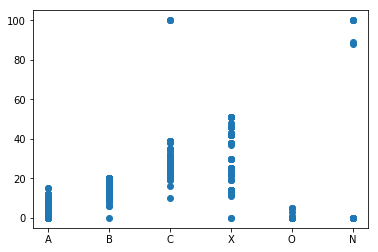

In [1428]:
fig, ax = plt.subplots(1,1) 
temp_train_data=train_data.dropna(subset=['CURRENT_GRADE','CURRENT_DEMERITS'])
ax.scatter(temp_train_data['CURRENT_GRADE'],temp_train_data['CURRENT_DEMERITS'])

Comments:

Both "CURRENT_GRADE" and "CURRENT_DEMERITS" has about 200 missing values.

"CURRENT_GRADE" is somewhat correlated to "CURRENT_DEMERITS", for example, most obseverations with grade A has less than 15 demerits.
If there is missing value in "CURRENT_DEMERITS", we could use the mean demetris of its corresponding grade to impute the missing value. 
If there is missing value in "CURRENT_GRADE", we could use the mode grade of its corresponding demerits to impute the missing value.

## Restaurant Type

In [30]:
train_data['RESTAURANT_CATEGORY'].value_counts(dropna=False)

Restaurant                     9319
Bar / Tavern                   2379
Snack Bar                      1285
Special Kitchen                1160
Buffet                          228
Portable Unit                   199
Pantry                          166
Meat/Poultry/Seafood            140
NaN                             130
Food Trucks / Mobile Vendor      99
Caterer                          71
Banquet Kitchen                  65
Kitchen Bakery                   61
Bakery Sales                     47
Garde Manger                     47
Vegetable Prep                   44
Produce Market                   33
Institutional Food Service       32
Concessions                      29
Confection                       26
Elementary School Kitchen        20
Grocery Store Sampling           19
Banquet Support                  16
Childcare Kitchens               15
Portable Bar                     15
Barbeque                         14
Main Kitchen                      8
Beer Bar                    

I grouped the variables into the following 8 types based on their characterics.

1. dinner-in restaurant type::Restaurant, Barbeque 
2. Bar type: Bar / Tavern,Beer Bar 
3. small food counter: Snack Bar, Concessions
4. kitech and food prepartion: Special Kitchen, Banquet Kitchen, Caterer,Banquet Support,Childcare Kitchens, Main Kitchen, Elementary School Kitchen, Institutional Food Service, Vegetable Prep
5. bakery type: Confection, Kitchen Bakery, Bakery Sales
6. Cooked food: Buffet, Garde Manger
7. Protably food service: Portable Unit,Food Trucks / Mobile Vendor,Portable Bar, Self-Service Food Truck 
8. grocery store type: Pantry, Meat/Poultry/Seafood, Grocery Store Sampling, Farmers Market, Produce Market

## Employee variables

In [31]:
train_data[train_data['EMPLOYEE_COUNT'].isnull()].shape

(93, 28)

In [32]:
train_data[train_data['MEDIAN_EMPLOYEE_AGE'].isnull()].shape

(34, 28)

In [33]:
train_data[train_data['MEDIAN_EMPLOYEE_TENURE'].isnull()].shape

(297, 28)

Comments:

These three numerical vairables all contains missing values.
One way to imput the missing value is to check the restaurant name or permit number and the information from different record of this restaurant to impute the missing value
In the previous method can not work, then we can impute the missing value using the mean.

## Inspection related variables

### inspection type and demerits

In [35]:
train_data['INSPECTION_TYPE'].value_counts(dropna=False)

Routine Inspection    14584
Re-inspection           867
NaN                     222
Name: INSPECTION_TYPE, dtype: int64

comments:

Most records are for routine inspection. Only a few records are for re-inspection. It is hard to imput the missing value, since we do not have the information to idenitfy whether the inspection is routine or re-inspection. I decided not to include this variable

In [36]:
train_data[train_data['INSPECTION_DEMERITS'].isnull()].shape

(254, 28)

In [1429]:
train_data[train_data['NUMBER_OF_VIOLATIONS'].isnull()].shape

(169, 28)

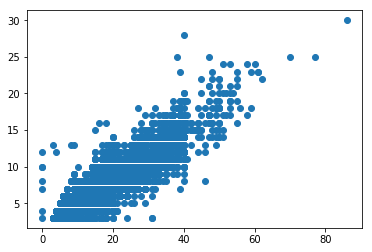

In [1430]:
fig, ax = plt.subplots(1,1) 
temp_train_data=train_data.dropna(subset=['INSPECTION_DEMERITS','NUMBER_OF_VIOLATIONS'])
ax.scatter(temp_train_data['INSPECTION_DEMERITS'],temp_train_data['NUMBER_OF_VIOLATIONS'])

comments:

Both 'INSPECTION_DEMERITS' and 'NUMBER_OF_VIOLATIONS' are numerical variables. These two variables both contains missing values. Based on the plot, these two variables are somewhat correlated to each other. We can build a simple linear regression model and use it to impute the missing values.

### Violation related

"VIOLATION_RAW','FIRST_VIOLATION','SECOND_VIOLATION', 'THIRD_VIOLATION', 'FIRST_VIOLATION_TYPE''SECOND_VIOLATION_TYPE', 'THIRD_VIOLATION_TYPE', "NUMBER_OF_VIOLATIONS"

'FIRST_VIOLATION_TYPE''SECOND_VIOLATION_TYPE', 'THIRD_VIOLATION_TYPE' and "NUMBER_OF_VIOLATIONS" these three variables will be used as the predictor variables for violation related variables

In [37]:
train_data['FIRST_VIOLATION_TYPE'].value_counts(dropna=False)

Critical                  7195
Major                     6740
Non-Major                 1589
NaN                        146
Imminent Health Hazard       3
Name: FIRST_VIOLATION_TYPE, dtype: int64

In [38]:
train_data['SECOND_VIOLATION_TYPE'].value_counts(dropna=False)

Major                     7909
Non-Major                 4507
Critical                  2985
NaN                        267
Imminent Health Hazard       5
Name: SECOND_VIOLATION_TYPE, dtype: int64

In [39]:
train_data['THIRD_VIOLATION_TYPE'].value_counts(dropna=False)

Major                     7310
Non-Major                 7286
Critical                   867
NaN                        173
Imminent Health Hazard      37
Name: THIRD_VIOLATION_TYPE, dtype: int64

All three violation types have missing values. The 'FIRST_VIOLATION','SECOND_VIOLATION', 'THIRD_VIOLATION' variables will be used to find the missin values in violation types. For the missing values in 'FIRST_VIOLATION','SECOND_VIOLATION', 'THIRD_VIOLATION', the VIOLATION_RAW will be used.

# Data Prepare

In [1215]:
train_data=pd.read_csv("TRAIN_SET.CSV")
test_data=pd.read_csv("TEST_SET.CSV")

In [1216]:
train_data.dropna(subset=["NEXT_INSPECTION_GRADE_C_OR_BELOW"], axis=0, how="all",inplace=True)
train_data.reset_index(drop=True,inplace=True)

comments:

some obseverations have missing values in target variables. I decided to remove these observations

## variable 1 - V_city

as described in section 3, there are 8 groups: Las Vegas, Henderson, North Las Vegas, Laughlin, Mesquite, Boulder City, Primm and other.

In [1217]:
# drop observations that have both missing values in city and zip
train_data.dropna(subset=['CITY',"ZIP"], axis=0, how="all",inplace=True)
train_data.reset_index(drop=True,inplace=True)

In [1220]:
# generate an index list for observations that have missing values in city
nan_index=train_data[train_data["CITY"].isnull()].index.tolist()

In [1221]:
# use zip to imput city
train_data["ZIP"]=train_data['ZIP'].str[0:5]
for i in range(0,train_data.shape[0]):
    if i in nan_index:
        temp_zip=train_data["ZIP"][i]
        train_data.loc[i,"CITY"] = train_data[train_data['ZIP']==temp_zip]['CITY'].value_counts().idxmax()

In [1222]:
# check nan
train_data["CITY"].value_counts(dropna=False)

Las Vegas          12520
Henderson           1535
North Las Vegas      911
Laughlin             199
Mesquite             160
Boulder City         133
Primm                103
Searchlight           14
Logandale             11
Indian Springs        11
Overton               10
Blue Diamond           5
Moapa                  4
Cal-Nev-Ari            3
Jean                   3
HendeSON               2
Goodsprings            2
Sandy Valley           2
HENDERSON              1
Name: CITY, dtype: int64

In [1223]:
# build grouping map

In [1224]:
location_map={"Las Vegas":"Las Vegas", 
              "Henderson":"Henderson", 
              "North Las Vegas":"North Las Vegas",
              "Laughlin":"Laughlin",
              "Mesquite":"Mesquite",
             "Boulder City":"Boulder City",
             "Primm":"Primm",
             "Searchlight":"Others",
             "Overton":"Others",
             "Logandale":"Others",
             "Indian Springs":"Others",
             "Blue Diamond":"Others",
             "Moapa":"Others",
             "Cal-Nev-Ari":"Others",
             "Jean":"Others",
             "HendeSON":"Henderson", 
             "Goodsprings":"Others",
             "Sandy Valley":"Others",
             "HENDERSON":"Henderson"}

In [1225]:
train_data["V_city"]=train_data["CITY"].map(location_map)

In [1226]:
test_data["V_city"]=test_data["CITY"].map(location_map)

In [1227]:
test_data["V_city"].fillna("Las Vegas",inplace=True)
# three observations has missing values in CITY, one is in Las Vegas, the other two does not have any zip code or address information, so I assume they are in las vegas too

## variable 2 - V_CURRENT_DEMERITS

In [1228]:
# drop observations that have both missing values in 'CURRENT_DEMERITS',"CURRENT_GRADE"
train_data.dropna(subset=['CURRENT_DEMERITS',"CURRENT_GRADE"], axis=0, how="all",inplace=True)
train_data.reset_index(drop=True,inplace=True)

In [1229]:
# impute missing value in 'CURRENT_DEMERITS' using the information in "CURRENT_GRADE"
nan_index=train_data[train_data["CURRENT_DEMERITS"].isnull()].index.tolist()
for i in range(0,train_data.shape[0]):
    if i in nan_index:
        temp_grade=train_data["CURRENT_GRADE"][i]
        train_data.loc[i,"CURRENT_DEMERITS"] = train_data[train_data["CURRENT_GRADE"]==temp_grade]['CURRENT_DEMERITS'].mean()

In [1230]:
train_data["V_CURRENT_DEMERITS"]=train_data["CURRENT_DEMERITS"]
test_data["V_CURRENT_DEMERITS"]=test_data["CURRENT_DEMERITS"]

## variable 3 - V_CURRENT_GRADE

In [1231]:
# impute missing value in  "CURRENT_GRADE" using the information in 'CURRENT_DEMERITS'
nan_index=train_data[train_data["CURRENT_GRADE"].isnull()].index.tolist()
for i in range(0,train_data.shape[0]):
    if i in nan_index:
        temp_DEMERITS=train_data["CURRENT_DEMERITS"][i]
        train_data.loc[i,"CURRENT_GRADE"] = train_data[train_data["CURRENT_DEMERITS"]==temp_DEMERITS]['CURRENT_GRADE'].value_counts().idxmax()

In [1232]:
train_data["V_CURRENT_GRADE"]=train_data["CURRENT_GRADE"]
test_data["V_CURRENT_GRADE"]=test_data["CURRENT_GRADE"]

In [1233]:
test_data["V_CURRENT_GRADE"].fillna("A",inplace=True)
# two observations has missing values in CURRENT_GRADE, since their permits are all 0, so I assume their grades are A.

## variable 4 - V_RESTAURANT_CATEGORY

In [1234]:
nan_index=train_data[train_data["RESTAURANT_CATEGORY"].isnull()].index.tolist()
for i in range(0,train_data.shape[0]):
    if i in nan_index:
        temp_permit_number=train_data["RESTAURANT_PERMIT_NUMBER"][i]
        temp_category = train_data[(train_data["RESTAURANT_PERMIT_NUMBER"]==temp_permit_number)&(train_data["RESTAURANT_CATEGORY"].notnull())]["RESTAURANT_CATEGORY"]
        #some restaurants only one record in the data. In that case, I will use the restaurant name to guess the type of the restaurant
        # for example, if a restaurant's name is "XXXX BBQ", the I assume it is a barbeque type restaurant
        if temp_category.empty:
            temp_name=train_data["RESTAURANT_NAME"][i]
            if "restaurant" in temp_name.lower():
                train_data["RESTAURANT_CATEGORY"][i] = "restaurant"
            elif "snack bar" in temp_name.lower():
                train_data["RESTAURANT_CATEGORY"][i] = "snack bar"
            elif "bar" in temp_name.lower():
                train_data["RESTAURANT_CATEGORY"][i] = "bar"
            elif "grade manager" in temp_name.lower():
                train_data["RESTAURANT_CATEGORY"][i] = "grade manage"
            elif "kitchen" in temp_name.lower():
                train_data["RESTAURANT_CATEGORY"][i] = "kitchen"
            elif "buffet" in temp_name.lower():
                train_data["RESTAURANT_CATEGORY"][i] = "buffet"
            elif "bbq" in temp_name.lower():
                train_data["RESTAURANT_CATEGORY"][i] = "barbeque"
            elif "barbeque" in temp_name.lower():
                train_data["RESTAURANT_CATEGORY"][i] = "barbeque"
            elif "bakery" in temp_name.lower():
                train_data["RESTAURANT_CATEGORY"][i] = "bakery"
        else:
            train_data.loc[i,"RESTAURANT_CATEGORY"] = temp_category.value_counts().idxmax()
        
        
        

E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be 

In [1235]:
train_data.dropna(subset=["RESTAURANT_CATEGORY"], axis=0, how="all",inplace=True)
train_data.reset_index(drop=True,inplace=True)

In [1236]:
restauranttype_map={"Restaurant":"type1", 
                    "restaurant":"type1",
                    "Barbeque":"type1", 
                      "Bar / Tavern":"type2",
                      "Beer Bar":"type2",
                    "bar":"type2",
                      "Snack Bar":"type3",
                    "snack bar":"type3", 
                      "Concessions":"type3",
                      "Special Kitchen":"type4",
                      "Banquet Kitchen":"type4",
                      "Caterer":"type4",
                  "Banquet Support":"type4",
                  "Childcare Kitchens":"type4",
                      "Main Kitchen":"type4",
                      "kitchen":"type4",
                      "Elementary School Kitchen":"type4",
                      "Institutional Food Service":"type4",
                      "Vegetable Prep":"type4",
                      "Confection":"type5", 
                      "Kitchen Bakery":"type5",
                      "Bakery Sales":"type5",
                   "Buffet":"type6",
                   "buffet":"type6",
                   "Garde Manger":"type6",
                   "Portable Unit":"type7",
                   "Food Trucks / Mobile Vendor":"type7",
                   "Portable Bar":"type7",
                   "Self-Service Food Truck":"type7",
                   "Pantry":"type8",
                   "Meat/Poultry/Seafood":"type8",
                   "Grocery Store Sampling":"type8",
                   "Farmers Market":"type8",
                   "Produce Market":"type8"}

In [1237]:
train_data["V_RESTAURANT_CATEGORY"]=train_data["RESTAURANT_CATEGORY"].map(restauranttype_map)

In [1238]:
test_data["V_RESTAURANT_CATEGORY"]=test_data["RESTAURANT_CATEGORY"].map(restauranttype_map)

In [1239]:
# check restaurant type
train_data["V_RESTAURANT_CATEGORY"].value_counts(dropna=False)

type1    9369
type2    2399
type4    1427
type3    1326
type8     359
type7     313
type6     278
type5     136
Name: V_RESTAURANT_CATEGORY, dtype: int64

1. dinner-in restaurant type::Restaurant, Barbeque 
2. Bar type: Bar / Tavern,Beer Bar 
3. small food counter: Snack Bar, Concessions
4. kitech and food prepartion: Special Kitchen, Banquet Kitchen, Caterer,Banquet Support,Childcare Kitchens, Main Kitchen, Elementary School Kitchen, Institutional Food Service, Vegetable Prep
5. bakery type: Confection, Kitchen Bakery, Bakery Sales
6. Cooked food: Buffet, Garde Manger
7. Protably food service: Portable Unit,Food Trucks / Mobile Vendor,Portable Bar, Self-Service Food Truck 
8. grocery store type: Pantry, Meat/Poultry/Seafood, Grocery Store Sampling, Farmers Market, Produce Market

## V_EMPLOYEE_COUNT

In [1240]:
nan_index=train_data[train_data["EMPLOYEE_COUNT"].isnull()].index.tolist()
for i in range(0,train_data.shape[0]):
    if i in nan_index:
        temp_permit_number=train_data["RESTAURANT_PERMIT_NUMBER"][i]
        temp_employee_count = train_data[(train_data["RESTAURANT_PERMIT_NUMBER"]==temp_permit_number)&(train_data["EMPLOYEE_COUNT"].notnull())]["EMPLOYEE_COUNT"]
        if temp_employee_count.empty:
            temp_type=train_data["V_RESTAURANT_CATEGORY"][i]
            temp_employee_count = train_data[(train_data["V_RESTAURANT_CATEGORY"]==temp_type)&(train_data["EMPLOYEE_COUNT"].notnull())]["EMPLOYEE_COUNT"]
            train_data.loc[i,"EMPLOYEE_COUNT"] = temp_employee_count.mean()
        else:
            train_data.loc[i,"EMPLOYEE_COUNT"] = temp_employee_count.mean()

In [1241]:
train_data["V_EMPLOYEE_COUNT"]=train_data["EMPLOYEE_COUNT"]
test_data["V_EMPLOYEE_COUNT"]=test_data["EMPLOYEE_COUNT"]

## V_MEDIAN_EMPLOYEE_AGE

In [1242]:
nan_index=train_data[train_data["MEDIAN_EMPLOYEE_AGE"].isnull()].index.tolist()
for i in range(0,train_data.shape[0]):
    if i in nan_index:
        temp_permit_number=train_data["RESTAURANT_PERMIT_NUMBER"][i]
        temp_age = train_data[(train_data["RESTAURANT_PERMIT_NUMBER"]==temp_permit_number)&(train_data["MEDIAN_EMPLOYEE_AGE"].notnull())]["MEDIAN_EMPLOYEE_AGE"]
        if temp_age.empty:
            temp_age = train_data[train_data["MEDIAN_EMPLOYEE_AGE"].notnull()]["MEDIAN_EMPLOYEE_AGE"]
            train_data.loc[i,"MEDIAN_EMPLOYEE_AGE"] = temp_age.mean()
        else:
            train_data.loc[i,"MEDIAN_EMPLOYEE_AGE"] = temp_age.mean()

In [1243]:
train_data["V_MEDIAN_EMPLOYEE_AGE"]=train_data["MEDIAN_EMPLOYEE_AGE"]
test_data["V_MEDIAN_EMPLOYEE_AGE"]=test_data["MEDIAN_EMPLOYEE_AGE"]

## V_MEDIAN_EMPLOYEE_TENURE

In [1244]:
nan_index=train_data[train_data["MEDIAN_EMPLOYEE_TENURE"].isnull()].index.tolist()
for i in range(0,train_data.shape[0]):
    if i in nan_index:
        temp_permit_number=train_data["RESTAURANT_PERMIT_NUMBER"][i]
        temp_tenure = train_data[(train_data["RESTAURANT_PERMIT_NUMBER"]==temp_permit_number)&(train_data["MEDIAN_EMPLOYEE_TENURE"].notnull())]["MEDIAN_EMPLOYEE_TENURE"]
        if temp_tenure.empty:
            temp_tenure = train_data[train_data["MEDIAN_EMPLOYEE_TENURE"].notnull()]["MEDIAN_EMPLOYEE_TENURE"]
            train_data.loc[i,"MEDIAN_EMPLOYEE_TENURE"] = temp_tenure.mean()
        else:
            train_data.loc[i,"MEDIAN_EMPLOYEE_TENURE"] = temp_tenure.mean()

In [1245]:
train_data["V_MEDIAN_EMPLOYEE_TENURE"]=train_data["MEDIAN_EMPLOYEE_TENURE"]
test_data["V_MEDIAN_EMPLOYEE_TENURE"]=test_data["MEDIAN_EMPLOYEE_TENURE"]

## V_INSPECTION_DEMERITS & V_NUMBER_OF_VIOLATIONS

In [1246]:
train_inspection_violations = train_data[["INSPECTION_DEMERITS", "NUMBER_OF_VIOLATIONS"]].copy()
train_inspection_violations.dropna(how="any",inplace=True)

In [1247]:
# build simple linear regression model to predict number of violation using inspection demertis
lm_model1 = LinearRegression(normalize=True)
lm_model1.fit(train_inspection_violations["INSPECTION_DEMERITS"].to_numpy().reshape(-1, 1),train_inspection_violations["NUMBER_OF_VIOLATIONS"].to_numpy())

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [1248]:
# build simple linear regression model to predict  nspection demertis using inumber of violation
lm_model2 = LinearRegression(normalize=True)
lm_model2.fit(train_inspection_violations["NUMBER_OF_VIOLATIONS"].to_numpy().reshape(-1, 1),train_inspection_violations["INSPECTION_DEMERITS"].to_numpy())

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [1249]:
lm_model2.predict(np.array(30).reshape(-1, 1))

array([74.28908075])

In [1250]:
train_data.dropna(subset=["INSPECTION_DEMERITS","NUMBER_OF_VIOLATIONS"], axis=0, how="all",inplace=True)
train_data.reset_index(drop=True,inplace=True)

In [1251]:
nan_index=train_data[train_data["INSPECTION_DEMERITS"].isnull()].index.tolist()
for i in range(0,train_data.shape[0]):
    if i in nan_index:
        temp_num_violations=train_data["NUMBER_OF_VIOLATIONS"][i]
        train_data.loc[i,"INSPECTION_DEMERITS"] = lm_model2.predict(np.array(temp_num_violations).reshape(-1, 1))

nan_index=train_data[train_data["NUMBER_OF_VIOLATIONS"].isnull()].index.tolist()
for i in range(0,train_data.shape[0]):
    if i in nan_index:
        temp_demerits=train_data["INSPECTION_DEMERITS"][i]
        train_data.loc[i,"NUMBER_OF_VIOLATIONS"] = lm_model1.predict(np.array(temp_demerits).reshape(-1, 1))

In [1252]:
train_data["V_INSPECTION_DEMERITS"]=train_data["INSPECTION_DEMERITS"]
test_data["V_INSPECTION_DEMERITS"]=test_data["INSPECTION_DEMERITS"]
train_data["V_NUMBER_OF_VIOLATIONS"]=train_data["NUMBER_OF_VIOLATIONS"]
test_data["V_NUMBER_OF_VIOLATIONS"]=test_data["NUMBER_OF_VIOLATIONS"]

## V_FIRST_VIOLATION, V_SECOND_VIOLATION, V_THIRD_VIOLATION 

This is the most tricky part in data preparation. First, I used the VIOLATIONS_RAW to find the missing values in First_violation, second_violation, third_violation. Then use First_violation, second_violation, third_violation to impute the missing violation type in "FIRST_VIOLATION_TYPE", "SECOND_VIOLATION_TYPE" and "THIRD_VIOLATION_TYPE"

In [1253]:
# replace missing values with 0 and convert all values to string
train_data["FIRST_VIOLATION"]=train_data["FIRST_VIOLATION"].fillna(0).astype(int).astype(str)

In [1254]:
train_data["SECOND_VIOLATION"]=train_data["SECOND_VIOLATION"].fillna(0).astype(int).astype(str)
train_data["THIRD_VIOLATION"]=train_data["THIRD_VIOLATION"].fillna(0).astype(int).astype(str)

In [1255]:
# remove the "," in the VIOLATIONS_RAW and combine all the number together
train_data["VIOLATIONS_RAW_combine"]=train_data["VIOLATIONS_RAW"].str.replace(',','')

In [1256]:
# split the string based on ","
train_data["VIOLATIONS_RAW_split"]=train_data["VIOLATIONS_RAW"].str.split(",")

It is important to note that, in "VIOLATIONS_RAW", the format is like "FIRST_VIOLATION,SECOND_VIOLATION,THIRD_VIOLATION". However some obseverations have the wrong format, where the comma was placed incorrectly. For example "20,921,221,621,729,200,000". The first violation should be 209 instead of 20. 
One thing I found is that if the second violation has only two numbers and these two numbers are correctly shown between the first and second comma in "VIOLATIONS_RAW", then the "VIOLATIONS_RAW" is in the correct format. The ones with incorrect format always have three numbers in the first violation, as a consequence, the second violation also has three numbers.

In [1257]:
nan_index=train_data[train_data["FIRST_VIOLATION"]=="0"].index.tolist()
for i in range(0,train_data.shape[0]):
    if i in nan_index:
        temp_string = train_data.loc[i,"VIOLATIONS_RAW_combine"]
        # if "VIOLATIONS_RAW" has missing value too, there is nothing we can do, so skip it and move to the next
        if temp_string!=temp_string:
            continue
        else:
            # check the string for the second violation, then the string for the first violation is just in front of the second one
            temp_checkmark=train_data.loc[i,"SECOND_VIOLATION"]
            train_data.loc[i,"FIRST_VIOLATION"] = re.search('(.*?)'+temp_checkmark, temp_string).group(1)
            


In [1258]:
nan_index=train_data[train_data["SECOND_VIOLATION"]=="0"].index.tolist()
for i in range(0,train_data.shape[0]):
    if i in nan_index:
        temp_string = train_data.loc[i,"VIOLATIONS_RAW_combine"]
        if temp_string!=temp_string:
            continue
        else:
            # check the string between first violation and third violation
            temp_checkmark1=train_data.loc[i,"FIRST_VIOLATION"]
            temp_checkmark2=train_data.loc[i,"THIRD_VIOLATION"]
            train_data.loc[i,"SECOND_VIOLATION"] = re.search(temp_checkmark1+'(.*?)'+temp_checkmark2, temp_string).group(1)


In [1259]:
nan_index=train_data[train_data["THIRD_VIOLATION"]=="0"].index.tolist()
for i in range(0,train_data.shape[0]):
    if i in nan_index:
        temp_string = train_data.loc[i,"VIOLATIONS_RAW_combine"]
        if temp_string!=temp_string:
            continue
        else:
            temp_checkmark1=train_data.loc[i,"FIRST_VIOLATION"]
            temp_checkmark2=train_data.loc[i,"SECOND_VIOLATION"]
            # if the second violation has 3 number, then use the 3 digits after second violation in VIOLATIONS_RAW
            if len(temp_checkmark2)==3:
                train_data.loc[i,"THIRD_VIOLATION"] = re.search(temp_checkmark2+'(.*)', temp_string).group(1)[0:3]
            # if the second violation has less then 3 number, then simply pick up the string between the second and third comma
            else:
                train_data.loc[i,"THIRD_VIOLATION"] = train_data.loc[i,"VIOLATIONS_RAW_split"][2]

In [1260]:
violation_1=train_data[["FIRST_VIOLATION_TYPE","FIRST_VIOLATION"]].rename(columns={'FIRST_VIOLATION_TYPE': 'VIOLATION_TYPE',
                                                                                   'FIRST_VIOLATION': 'VIOLATION'})
violation_2=train_data[["SECOND_VIOLATION_TYPE","SECOND_VIOLATION"]].rename(columns={'SECOND_VIOLATION_TYPE': 'VIOLATION_TYPE',
                                                                                   'SECOND_VIOLATION': 'VIOLATION'})
violation_3=train_data[["THIRD_VIOLATION_TYPE","THIRD_VIOLATION"]].rename(columns={'THIRD_VIOLATION_TYPE': 'VIOLATION_TYPE',
                                                                                   'THIRD_VIOLATION': 'VIOLATION'})


violation_type_check=pd.concat([violation_1,violation_2,violation_3])


Now most missing violation codes have been imputed. It is time to use the violation codes to find the missing value in violation types

In [1261]:
violation_type_check.dropna(axis=0, how="all",inplace=True)

In [1262]:
critical_list=violation_type_check[violation_type_check['VIOLATION_TYPE']=="Critical"]['VIOLATION'].unique().tolist()

In [1263]:
major_list=violation_type_check[violation_type_check['VIOLATION_TYPE']=="Major"]['VIOLATION'].unique().tolist()

In [1264]:
nomajor_list=violation_type_check[violation_type_check['VIOLATION_TYPE']=="Non-Major"]['VIOLATION'].unique().tolist()

In [1265]:
ihh_list=violation_type_check[violation_type_check['VIOLATION_TYPE']=="Imminent Health Hazard"]['VIOLATION'].unique().tolist()

In [1266]:
nan_index=train_data[train_data["FIRST_VIOLATION_TYPE"].isnull()].index.tolist()
for i in range(0,train_data.shape[0]):
    if i in nan_index:
        temp_vio_code = train_data.loc[i,"FIRST_VIOLATION"]
        if temp_vio_code!=temp_vio_code:
            continue
        elif temp_vio_code in critical_list:
            train_data.loc[i,"FIRST_VIOLATION_TYPE"]="Critical"
        elif temp_vio_code in major_list:
            train_data.loc[i,"FIRST_VIOLATION_TYPE"]="Major"
        elif temp_vio_code in nomajor_list:
            train_data.loc[i,"FIRST_VIOLATION_TYPE"]="Non-Major"
        else:
            train_data.loc[i,"FIRST_VIOLATION_TYPE"]="Imminent Health Hazard"
        
  

In [1267]:
nan_index=train_data[train_data["SECOND_VIOLATION_TYPE"].isnull()].index.tolist()
for i in range(0,train_data.shape[0]):
    if i in nan_index:
        temp_vio_code = train_data.loc[i,"SECOND_VIOLATION"]
        if temp_vio_code!=temp_vio_code:
            continue
        elif temp_vio_code in critical_list:
            train_data.loc[i,"SECOND_VIOLATION_TYPE"]="Critical"
        elif temp_vio_code in major_list:
            train_data.loc[i,"SECOND_VIOLATION_TYPE"]="Major"
        elif temp_vio_code in nomajor_list:
            train_data.loc[i,"SECOND_VIOLATION_TYPE"]="Non-Major"
        else:
            train_data.loc[i,"SECOND_VIOLATION_TYPE"]="Imminent Health Hazard"

In [1268]:
nan_index=train_data[train_data["THIRD_VIOLATION_TYPE"].isnull()].index.tolist()
for i in range(0,train_data.shape[0]):
    if i in nan_index:
        temp_vio_code = train_data.loc[i,"THIRD_VIOLATION"]
        if temp_vio_code!=temp_vio_code:
            continue
        elif temp_vio_code in critical_list:
            train_data.loc[i,"THIRD_VIOLATION_TYPE"]="Critical"
        elif temp_vio_code in major_list:
            train_data.loc[i,"THIRD_VIOLATION_TYPE"]="Major"
        elif temp_vio_code in nomajor_list:
            train_data.loc[i,"THIRD_VIOLATION_TYPE"]="Non-Major"
        else:
            train_data.loc[i,"THIRD_VIOLATION_TYPE"]="Imminent Health Hazard"

In [1282]:
# in test dataset column:FIRST_VIOLATION_TYPE, there is a type "1", maybe input error. so use FIRST_VIOLATION to encode it
nan_index=test_data[test_data["FIRST_VIOLATION_TYPE"]=="1"].index.tolist()
for i in range(0,test_data.shape[0]):
    if i in nan_index:
        temp_vio_code = test_data.loc[i,"FIRST_VIOLATION"]
        if temp_vio_code!=temp_vio_code:
            continue
        elif temp_vio_code in critical_list:
            test_data.loc[i,"FIRST_VIOLATION_TYPE"]="Critical"
        elif temp_vio_code in major_list:
            test_data.loc[i,"FIRST_VIOLATION_TYPE"]="Major"
        elif temp_vio_code in nomajor_list:
            test_data.loc[i,"FIRST_VIOLATION_TYPE"]="Non-Major"
        else:
            test_data.loc[i,"FIRST_VIOLATION_TYPE"]="Imminent Health Hazard"

In [1284]:
train_data["V_FIRST_VIOLATION_TYPE"]=train_data["FIRST_VIOLATION_TYPE"]
train_data["V_SECOND_VIOLATION_TYPE"]=train_data["SECOND_VIOLATION_TYPE"]
train_data["V_THIRD_VIOLATION_TYPE"]=train_data["THIRD_VIOLATION_TYPE"]
test_data["V_FIRST_VIOLATION_TYPE"]=test_data["FIRST_VIOLATION_TYPE"]
test_data["V_SECOND_VIOLATION_TYPE"]=test_data["SECOND_VIOLATION_TYPE"]
test_data["V_THIRD_VIOLATION_TYPE"]=test_data["THIRD_VIOLATION_TYPE"]

## create the clean dataframe

Create a clean dataframe for modeling

In [1285]:
col_names=['V_city', 
           'V_CURRENT_DEMERITS',
           'V_CURRENT_GRADE', 
           'V_RESTAURANT_CATEGORY', 
           'V_EMPLOYEE_COUNT',
           'V_MEDIAN_EMPLOYEE_AGE', 
           'V_MEDIAN_EMPLOYEE_TENURE',
           'V_INSPECTION_DEMERITS', 
           'V_NUMBER_OF_VIOLATIONS',
           'V_FIRST_VIOLATION_TYPE', 
           'V_SECOND_VIOLATION_TYPE',
           'V_THIRD_VIOLATION_TYPE']

In [1286]:
X_train = train_data[col_names]
X_test = test_data[col_names]

In [1287]:
X_train.isnull().values.any()

False

In [1288]:
X_test.isnull().values.any()

False

In [1289]:
Y_train = train_data["NEXT_INSPECTION_GRADE_C_OR_BELOW"].astype(int)

In [1290]:
clean_train_data=pd.concat([X_train,Y_train],axis=1)

In [1291]:
clean_train_data.to_csv("clean_train_data.csv",index=False)

In [1292]:
X_test.to_csv("clean_test_data.csv",index=False)

# Modeling

In [1293]:
clean_train_data=pd.read_csv("clean_train_data.csv")
clean_test_data=pd.read_csv("clean_test_data.csv")

In [1294]:
cat_col_names=["V_city", "V_CURRENT_GRADE", "V_RESTAURANT_CATEGORY", "V_FIRST_VIOLATION_TYPE", "V_SECOND_VIOLATION_TYPE", "V_THIRD_VIOLATION_TYPE"]

## Encode the categorical variables

I used one hot encoding to encode the categroical variables

In [1296]:
LE=LabelEncoder()
colencoder=OneHotEncoder()

for i in cat_col_names:
    clean_train_data[i] = LE.fit_transform(clean_train_data[i])
    clean_test_data[i] = LE.transform(clean_test_data[i])
    tempcol_train = colencoder.fit_transform(clean_train_data[i].values.reshape(-1,1)).toarray()
    tempcol_test = colencoder.transform(clean_test_data[i].values.reshape(-1,1)).toarray()
    
    dftempcol_train = pd.DataFrame(tempcol_train, columns = [i+"_"+str(j) for j in LE.classes_])
    clean_train_data = pd.concat([clean_train_data, dftempcol_train], axis=1)
    clean_train_data = clean_train_data.drop([i],axis=1)
    
    dftempcol_test = pd.DataFrame(tempcol_test, columns = [i+"_"+str(j) for j in LE.classes_])
    clean_test_data = pd.concat([clean_test_data, dftempcol_test], axis=1)
    clean_test_data = clean_test_data.drop([i],axis=1)

E:\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
E:\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before

In [1308]:
X_train = clean_train_data.loc[:,clean_train_data.columns != "NEXT_INSPECTION_GRADE_C_OR_BELOW"]

In [1310]:
Y_train=clean_train_data["NEXT_INSPECTION_GRADE_C_OR_BELOW"]

In [1318]:
Y_train.value_counts()

0    13137
1     2466
Name: NEXT_INSPECTION_GRADE_C_OR_BELOW, dtype: int64

In [1353]:
X_test = clean_test_data

1. It seems that the dataset has some imbalance issue. About 6/7 obseverations belong to class 0 and only 1/7 obseverations belong to class 1.
2. I used xgboost modeling package, since xgboost is a very powerful gradient boosted tree model. It can handle both numerical variables and categroical variables. Correlation variables will not cause any issue in the modeling results. In addition, tree-based model can easily capture the interation effects in the dataset, so I do not have to include any interaction term explictly. 
3. Since we only have about 15K obseverations, I decided to use cross-validation to build my model. So all the infomations in the training set will be included in the model. In addition, xgboost model requires a validation set to determine the number of iteration we want to use in the model, so we could prevent overfitting.
4. Regarding the stopping metric, I tried aucpr, auc, classification error and logloss. It is hard to say which one would lead to the best model, so I tried them both
5. The metric I used to evaluate model performance is f1-score. After building models using different stopping metric, I obtained the threshold that maximize the f1 socre on the cross-validation set and see which one works the best.
6. I also tried balancing the class using upper sampling method. But the results did not improve.

## use acupr as metric

In [1325]:
# tuning model parameters
parameters = {'objective':['binary:logistic'],
              "grow_policy": ["lossguide"],
              'learning_rate': [0.01], #so called `eta` value
              'max_leaves': [2,3],
              'min_child_weight': [1,20,100],
              "scale_pos_weight": [1],
              'subsample': [1, 0.8, 0.6],
              'colsample_bytree': [1, 0.8, 0.6],
              'seed': [1337]}

searchgrid = ParameterGrid(parameters)

dtrain=xgb.DMatrix(X_train,label =Y_train)


max_aucpr = 0.0

for i in range(0, len(searchgrid)):
    params = searchgrid[i]
    bst = xgb.cv(params, 
           dtrain, 
           num_boost_round = 100000,
           nfold=5,
           #feval = f1_eval,
           #maximize = True,
           metrics="aucpr",
           verbose_eval =100,
           early_stopping_rounds = 100)

    
    mean_aucpr = bst['test-aucpr-mean'].max()
    boost_rounds = bst['test-aucpr-mean'].argmax()
    print("\taucpr {} for {} rounds".format(mean_aucpr, boost_rounds))
    if mean_aucpr > max_aucpr:
        max_aucpr = mean_aucpr
        print(params)

[0]	train-aucpr:0.24697+0.00575	test-aucpr:0.18481+0.01673
[100]	train-aucpr:0.32096+0.00633	test-aucpr:0.19491+0.01451
[200]	train-aucpr:0.37573+0.00193	test-aucpr:0.19446+0.01455
	aucpr 0.195317 for 130 rounds
{'subsample': 1, 'seed': 1337, 'scale_pos_weight': 1, 'objective': 'binary:logistic', 'min_child_weight': 1, 'max_leaves': 2, 'learning_rate': 0.01, 'grow_policy': 'lossguide', 'colsample_bytree': 1}
[0]	train-aucpr:0.23318+0.00300	test-aucpr:0.18571+0.01570


E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.


[100]	train-aucpr:0.33681+0.00976	test-aucpr:0.19585+0.01203
[200]	train-aucpr:0.39009+0.01013	test-aucpr:0.19605+0.01170
	aucpr 0.1967946 for 134 rounds
{'subsample': 0.8, 'seed': 1337, 'scale_pos_weight': 1, 'objective': 'binary:logistic', 'min_child_weight': 1, 'max_leaves': 2, 'learning_rate': 0.01, 'grow_policy': 'lossguide', 'colsample_bytree': 1}
[0]	train-aucpr:0.21982+0.00231	test-aucpr:0.18091+0.01300
[100]	train-aucpr:0.32638+0.00864	test-aucpr:0.19716+0.01179
	aucpr 0.1980004 for 58 rounds
{'subsample': 0.6, 'seed': 1337, 'scale_pos_weight': 1, 'objective': 'binary:logistic', 'min_child_weight': 1, 'max_leaves': 2, 'learning_rate': 0.01, 'grow_policy': 'lossguide', 'colsample_bytree': 1}
[0]	train-aucpr:0.22568+0.00347	test-aucpr:0.18474+0.01814
[100]	train-aucpr:0.26488+0.00490	test-aucpr:0.19219+0.01367
[200]	train-aucpr:0.28301+0.00453	test-aucpr:0.19304+0.01210
[300]	train-aucpr:0.29673+0.00361	test-aucpr:0.19399+0.01182
	aucpr 0.1942724 for 279 rounds
[0]	train-aucpr:0

	aucpr 0.2024098 for 98 rounds
{'subsample': 0.6, 'seed': 1337, 'scale_pos_weight': 1, 'objective': 'binary:logistic', 'min_child_weight': 1, 'max_leaves': 2, 'learning_rate': 0.01, 'grow_policy': 'lossguide', 'colsample_bytree': 0.6}
[0]	train-aucpr:0.21398+0.00314	test-aucpr:0.17924+0.00776
[100]	train-aucpr:0.26688+0.00429	test-aucpr:0.19679+0.01136
	aucpr 0.1974604 for 34 rounds
[0]	train-aucpr:0.20703+0.00217	test-aucpr:0.18743+0.00698
[100]	train-aucpr:0.26464+0.00368	test-aucpr:0.19966+0.00828
[200]	train-aucpr:0.27930+0.00516	test-aucpr:0.19931+0.00978
	aucpr 0.2003502 for 120 rounds
[0]	train-aucpr:0.19994+0.00528	test-aucpr:0.18415+0.00953
[100]	train-aucpr:0.25808+0.00286	test-aucpr:0.19656+0.00821
[200]	train-aucpr:0.27024+0.00400	test-aucpr:0.19744+0.00832
	aucpr 0.1977798 for 159 rounds
[0]	train-aucpr:0.19880+0.00055	test-aucpr:0.18951+0.00555
[100]	train-aucpr:0.22634+0.00412	test-aucpr:0.19189+0.00725
	aucpr 0.1929416 for 17 rounds
[0]	train-aucpr:0.19615+0.00059	test-

In [1327]:
# tuning learning rate
parameters = {'objective':['binary:logistic'],
              "grow_policy": ["lossguide"],
              'learning_rate': [0.2, 0.1, 0.05,0.01,0.005,0.001], #so called `eta` value
              'max_leaves': [2],
              'min_child_weight': [1],
              "scale_pos_weight": [1],
              'subsample': [0.6],
              'colsample_bytree': [0.6],
              'seed': [1337]}

searchgrid = ParameterGrid(parameters)

dtrain=xgb.DMatrix(X_train,label =Y_train)


max_aucpr = 0.0

for i in range(0, len(searchgrid)):
    params = searchgrid[i]
    bst = xgb.cv(params, 
           dtrain, 
           num_boost_round = 100000,
           nfold=5,
           #feval = f1_eval,
           #maximize = True,
           metrics="aucpr",
           verbose_eval =100,
           early_stopping_rounds = 100)

    
    mean_aucpr = bst['test-aucpr-mean'].max()
    boost_rounds = bst['test-aucpr-mean'].argmax()
    print("\taucpr {} for {} rounds".format(mean_aucpr, boost_rounds))
    if mean_aucpr > max_aucpr:
        max_aucpr = mean_aucpr
        print(params)

[0]	train-aucpr:0.21221+0.00485	test-aucpr:0.18191+0.00810
[100]	train-aucpr:0.70419+0.00797	test-aucpr:0.17661+0.01223
	aucpr 0.1915196 for 5 rounds
{'subsample': 0.6, 'seed': 1337, 'scale_pos_weight': 1, 'objective': 'binary:logistic', 'min_child_weight': 1, 'max_leaves': 2, 'learning_rate': 0.2, 'grow_policy': 'lossguide', 'colsample_bytree': 0.6}
[0]	train-aucpr:0.21221+0.00485	test-aucpr:0.18191+0.00810


E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.


[100]	train-aucpr:0.59107+0.00744	test-aucpr:0.18362+0.01172
	aucpr 0.19311499999999998 for 9 rounds
{'subsample': 0.6, 'seed': 1337, 'scale_pos_weight': 1, 'objective': 'binary:logistic', 'min_child_weight': 1, 'max_leaves': 2, 'learning_rate': 0.1, 'grow_policy': 'lossguide', 'colsample_bytree': 0.6}
[0]	train-aucpr:0.21221+0.00485	test-aucpr:0.18191+0.00810
[100]	train-aucpr:0.46443+0.00948	test-aucpr:0.19290+0.01279
	aucpr 0.196749 for 37 rounds
{'subsample': 0.6, 'seed': 1337, 'scale_pos_weight': 1, 'objective': 'binary:logistic', 'min_child_weight': 1, 'max_leaves': 2, 'learning_rate': 0.05, 'grow_policy': 'lossguide', 'colsample_bytree': 0.6}
[0]	train-aucpr:0.21221+0.00485	test-aucpr:0.18191+0.00810
[100]	train-aucpr:0.31682+0.00945	test-aucpr:0.20193+0.00996
	aucpr 0.2024098 for 98 rounds
{'subsample': 0.6, 'seed': 1337, 'scale_pos_weight': 1, 'objective': 'binary:logistic', 'min_child_weight': 1, 'max_leaves': 2, 'learning_rate': 0.01, 'grow_policy': 'lossguide', 'colsample_b

In [1370]:
#def f1_eval(y_pred, dtrain):
#    y_true = dtrain.get_label()
#    err = 1-f1_score(y_true, np.round(y_pred),average="binary")
#    return 'f1_err', err

# build model and make prediction on validation sets and test set

model = XGBClassifier( n_estimators=10000,
                        max_leaves=2,
                        grow_policy = "lossguide",
                        objective="binary:logistic",
                        learning_rate=0.01, 
                        subsample=.6,
                        min_child_weight=1,
                        colsample_bytree=.6,
                        scale_pos_weight=1)


cv_train = np.zeros(len(X_train))
cv_test = np.zeros(len(X_test))
kf = StratifiedKFold(n_splits=5, shuffle=False, random_state=123)
for i, (train_index, test_index) in enumerate(kf.split(X_train,Y_train)):
    print( "\nFold ", i)
    y_train, y_valid = Y_train.iloc[train_index].copy(), Y_train.iloc[test_index]
    x_train, x_valid = X_train.iloc[train_index,:].copy(), X_train.iloc[test_index,:].copy()
    val_set=[(x_valid,y_valid)]
    fit_model = model.fit(x_train, y_train, 
                          eval_set=val_set,
                          eval_metric="aucpr",
                          early_stopping_rounds=100,
                          verbose=100
                             )
    cv_train[test_index] +=fit_model.predict_proba(x_valid, ntree_limit=fit_model.best_ntree_limit)[:,1]
    cv_test +=fit_model.predict_proba(X_test, ntree_limit=fit_model.best_ntree_limit)[:,1]
    
cv_test=cv_test/5
    



Fold  0
[0]	validation_0-aucpr:0.18596
Will train until validation_0-aucpr hasn't improved in 100 rounds.
[100]	validation_0-aucpr:0.20651
Stopping. Best iteration:
[56]	validation_0-aucpr:0.21106


Fold  1
[0]	validation_0-aucpr:0.18176
Will train until validation_0-aucpr hasn't improved in 100 rounds.
[100]	validation_0-aucpr:0.20100
Stopping. Best iteration:
[8]	validation_0-aucpr:0.20252


Fold  2
[0]	validation_0-aucpr:0.18450
Will train until validation_0-aucpr hasn't improved in 100 rounds.
[100]	validation_0-aucpr:0.19707
Stopping. Best iteration:
[39]	validation_0-aucpr:0.19851


Fold  3
[0]	validation_0-aucpr:0.20845
Will train until validation_0-aucpr hasn't improved in 100 rounds.
[100]	validation_0-aucpr:0.21860
Stopping. Best iteration:
[90]	validation_0-aucpr:0.21921


Fold  4
[0]	validation_0-aucpr:0.17591
Will train until validation_0-aucpr hasn't improved in 100 rounds.
[100]	validation_0-aucpr:0.18482
Stopping. Best iteration:
[50]	validation_0-aucpr:0.18760



In [1372]:
precision_train, recall_train, thresholds = precision_recall_curve(Y_train, cv_train)
f1_scores_train = 2*recall_train*precision_train/(recall_train+precision_train)
print('Best threshold: ', thresholds[np.argmax(f1_scores_train)])
print('Best F1-Score: ', np.max(f1_scores_train))

Best threshold:  0.2892748713493347
Best F1-Score:  0.27501505117399155


if we use aucpr to build the model, the best f1-score from cross-validation is 0.275

## use logloss as metric

In [1375]:
parameters = {'objective':['binary:logistic'],
              "grow_policy": ["lossguide"],
              'learning_rate': [0.01], #so called `eta` value
              'max_leaves': [2,3],
              'min_child_weight': [1,20,100],
              "scale_pos_weight": [1],
              'subsample': [1, 0.8, 0.6],
              'colsample_bytree': [1, 0.8, 0.6],
              'seed': [1337]}

searchgrid = ParameterGrid(parameters)

dtrain=xgb.DMatrix(X_train,label =Y_train)


min_logloss = 10000000000000.0

for i in range(0, len(searchgrid)):
    params = searchgrid[i]
    bst = xgb.cv(params, 
           dtrain, 
           num_boost_round = 100000,
           nfold=5,
           #feval = f1_eval,
           #maximize = True,
           metrics="logloss",
           verbose_eval =100,
           early_stopping_rounds = 100)

    
    mean_logloss = bst['test-logloss-mean'].min()
    boost_rounds = bst['test-logloss-mean'].argmin()
    print("\tlogloss{} for {} rounds".format(mean_logloss, boost_rounds))
    if mean_logloss < min_logloss:
        min_logloss = mean_logloss
        print(params)

[0]	train-logloss:0.68836+0.00006	test-logloss:0.68845+0.00007
[100]	train-logloss:0.46722+0.00281	test-logloss:0.47688+0.00585
[200]	train-logloss:0.41987+0.00345	test-logloss:0.44054+0.00933
[300]	train-logloss:0.40507+0.00397	test-logloss:0.43524+0.01121
[400]	train-logloss:0.39800+0.00337	test-logloss:0.43492+0.01171
	logloss0.4348032 for 359 rounds
{'subsample': 1, 'seed': 1337, 'scale_pos_weight': 1, 'objective': 'binary:logistic', 'min_child_weight': 1, 'max_leaves': 2, 'learning_rate': 0.01, 'grow_policy': 'lossguide', 'colsample_bytree': 1}
[0]	train-logloss:0.68835+0.00007	test-logloss:0.68843+0.00006


E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.


[100]	train-logloss:0.46693+0.00260	test-logloss:0.47684+0.00616
[200]	train-logloss:0.41894+0.00315	test-logloss:0.44023+0.00979
[300]	train-logloss:0.40257+0.00344	test-logloss:0.43487+0.01144
[400]	train-logloss:0.39256+0.00313	test-logloss:0.43471+0.01187
	logloss0.43457339999999994 for 352 rounds
{'subsample': 0.8, 'seed': 1337, 'scale_pos_weight': 1, 'objective': 'binary:logistic', 'min_child_weight': 1, 'max_leaves': 2, 'learning_rate': 0.01, 'grow_policy': 'lossguide', 'colsample_bytree': 1}
[0]	train-logloss:0.68839+0.00007	test-logloss:0.68848+0.00008
[100]	train-logloss:0.46770+0.00268	test-logloss:0.47679+0.00630
[200]	train-logloss:0.42034+0.00320	test-logloss:0.44006+0.00999
[300]	train-logloss:0.40412+0.00311	test-logloss:0.43440+0.01172
[400]	train-logloss:0.39386+0.00307	test-logloss:0.43428+0.01219
	logloss0.4341144 for 348 rounds
{'subsample': 0.6, 'seed': 1337, 'scale_pos_weight': 1, 'objective': 'binary:logistic', 'min_child_weight': 1, 'max_leaves': 2, 'learning_r

[100]	train-logloss:0.47131+0.00254	test-logloss:0.47719+0.00639
[200]	train-logloss:0.42877+0.00309	test-logloss:0.44039+0.00992
[300]	train-logloss:0.41826+0.00304	test-logloss:0.43468+0.01151
[400]	train-logloss:0.41348+0.00270	test-logloss:0.43453+0.01215
	logloss0.4343868000000001 for 355 rounds
[0]	train-logloss:0.68842+0.00006	test-logloss:0.68846+0.00008
[100]	train-logloss:0.47160+0.00249	test-logloss:0.47718+0.00658
[200]	train-logloss:0.42884+0.00282	test-logloss:0.44022+0.01016
[300]	train-logloss:0.41751+0.00292	test-logloss:0.43461+0.01184
[400]	train-logloss:0.41228+0.00285	test-logloss:0.43433+0.01238
	logloss0.4342586 for 366 rounds
[0]	train-logloss:0.68845+0.00007	test-logloss:0.68849+0.00007
[100]	train-logloss:0.47238+0.00256	test-logloss:0.47738+0.00652
[200]	train-logloss:0.42999+0.00290	test-logloss:0.44039+0.01010
[300]	train-logloss:0.41906+0.00286	test-logloss:0.43462+0.01180
[400]	train-logloss:0.41388+0.00283	test-logloss:0.43448+0.01237
	logloss0.434280599

[400]	train-logloss:0.42422+0.00297	test-logloss:0.43418+0.01230
	logloss0.43415440000000005 for 375 rounds
[0]	train-logloss:0.68843+0.00006	test-logloss:0.68844+0.00008
[100]	train-logloss:0.47491+0.00253	test-logloss:0.47737+0.00649
[200]	train-logloss:0.43567+0.00301	test-logloss:0.44051+0.01007
[300]	train-logloss:0.42769+0.00309	test-logloss:0.43461+0.01176
[400]	train-logloss:0.42523+0.00311	test-logloss:0.43396+0.01248
[500]	train-logloss:0.42380+0.00308	test-logloss:0.43421+0.01278
	logloss0.4339518 for 401 rounds
[0]	train-logloss:0.68846+0.00008	test-logloss:0.68847+0.00007
[100]	train-logloss:0.47543+0.00257	test-logloss:0.47733+0.00652
[200]	train-logloss:0.43666+0.00301	test-logloss:0.44043+0.01012
[300]	train-logloss:0.42906+0.00309	test-logloss:0.43447+0.01176
[400]	train-logloss:0.42695+0.00309	test-logloss:0.43371+0.01240
[500]	train-logloss:0.42584+0.00305	test-logloss:0.43381+0.01266
	logloss0.4336882 for 423 rounds
[0]	train-logloss:0.68839+0.00005	test-logloss:0.6

In [1377]:
parameters = {'objective':['binary:logistic'],
              "grow_policy": ["lossguide"],
              'learning_rate': [0.01, 0.005, 0.001], #so called `eta` value
              'max_leaves': [2],
              'min_child_weight': [1],
              "scale_pos_weight": [1],
              'subsample': [0.6],
              'colsample_bytree': [0.6],
              'seed': [1337]}

searchgrid = ParameterGrid(parameters)

dtrain=xgb.DMatrix(X_train,label =Y_train)


min_logloss = 10000000000000.0

for i in range(0, len(searchgrid)):
    params = searchgrid[i]
    bst = xgb.cv(params, 
           dtrain, 
           num_boost_round = 100000,
           nfold=5,
           #feval = f1_eval,
           #maximize = True,
           metrics="logloss",
           verbose_eval =100,
           early_stopping_rounds = 100)

    
    mean_logloss = bst['test-logloss-mean'].min()
    boost_rounds = bst['test-logloss-mean'].argmin()
    print("\tlogloss{} for {} rounds".format(mean_logloss, boost_rounds))
    if mean_logloss < min_logloss:
        min_logloss = mean_logloss
        print(params)

[0]	train-logloss:0.68842+0.00008	test-logloss:0.68847+0.00008
[100]	train-logloss:0.46924+0.00265	test-logloss:0.47674+0.00632
[200]	train-logloss:0.42330+0.00312	test-logloss:0.43971+0.00990
[300]	train-logloss:0.40854+0.00288	test-logloss:0.43401+0.01150
[400]	train-logloss:0.39948+0.00287	test-logloss:0.43369+0.01202
	logloss0.43362740000000005 for 392 rounds
{'subsample': 0.6, 'seed': 1337, 'scale_pos_weight': 1, 'objective': 'binary:logistic', 'min_child_weight': 1, 'max_leaves': 2, 'learning_rate': 0.01, 'grow_policy': 'lossguide', 'colsample_bytree': 0.6}
[0]	train-logloss:0.69078+0.00004	test-logloss:0.69080+0.00004


E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.


[100]	train-logloss:0.53617+0.00181	test-logloss:0.53976+0.00359
[200]	train-logloss:0.46976+0.00254	test-logloss:0.47727+0.00638
[300]	train-logloss:0.43891+0.00288	test-logloss:0.45080+0.00848
[400]	train-logloss:0.42335+0.00293	test-logloss:0.43979+0.00997
[500]	train-logloss:0.41463+0.00291	test-logloss:0.43548+0.01099
[600]	train-logloss:0.40852+0.00300	test-logloss:0.43392+0.01162
[700]	train-logloss:0.40386+0.00297	test-logloss:0.43353+0.01203
[800]	train-logloss:0.39962+0.00313	test-logloss:0.43349+0.01225
	logloss0.43343420000000005 for 770 rounds
{'subsample': 0.6, 'seed': 1337, 'scale_pos_weight': 1, 'objective': 'binary:logistic', 'min_child_weight': 1, 'max_leaves': 2, 'learning_rate': 0.005, 'grow_policy': 'lossguide', 'colsample_bytree': 0.6}
[0]	train-logloss:0.69267+0.00001	test-logloss:0.69268+0.00001
[100]	train-logloss:0.64938+0.00050	test-logloss:0.65007+0.00078
[200]	train-logloss:0.61348+0.00089	test-logloss:0.61487+0.00154
[300]	train-logloss:0.58348+0.00125	tes

In [1378]:
model = XGBClassifier( n_estimators=10000,
                        max_leaves=2,
                        grow_policy = "lossguide",
                        objective="binary:logistic",
                        learning_rate=0.001, 
                        subsample=.6,
                        min_child_weight=1,
                        colsample_bytree=.6,
                        scale_pos_weight=1)


cv_train = np.zeros(len(X_train))
cv_test = np.zeros(len(X_test))
kf = StratifiedKFold(n_splits=5, shuffle=False, random_state=123)
for i, (train_index, test_index) in enumerate(kf.split(X_train,Y_train)):
    print( "\nFold ", i)
    y_train, y_valid = Y_train.iloc[train_index].copy(), Y_train.iloc[test_index]
    x_train, x_valid = X_train.iloc[train_index,:].copy(), X_train.iloc[test_index,:].copy()
    val_set=[(x_valid,y_valid)]
    fit_model = model.fit(x_train, y_train, 
                          eval_set=val_set,
                          eval_metric="logloss",
                          early_stopping_rounds=100,
                          verbose=100
                             )
    cv_train[test_index] +=fit_model.predict_proba(x_valid, ntree_limit=fit_model.best_ntree_limit)[:,1]
    cv_test +=fit_model.predict_proba(X_test, ntree_limit=fit_model.best_ntree_limit)[:,1]
    
cv_test=cv_test/5

precision_train, recall_train, thresholds = precision_recall_curve(Y_train, cv_train)
f1_scores_train = 2*recall_train*precision_train/(recall_train+precision_train)
print('Best threshold: ', thresholds[np.argmax(f1_scores_train)])
print('Best F1-Score: ', np.max(f1_scores_train))


Fold  0
[0]	validation_0-logloss:0.69268
Will train until validation_0-logloss hasn't improved in 100 rounds.
[100]	validation_0-logloss:0.65015
[200]	validation_0-logloss:0.61492
[300]	validation_0-logloss:0.58571
[400]	validation_0-logloss:0.56123
[500]	validation_0-logloss:0.54071
[600]	validation_0-logloss:0.52342
[700]	validation_0-logloss:0.50884
[800]	validation_0-logloss:0.49657
[900]	validation_0-logloss:0.48622
[1000]	validation_0-logloss:0.47750
[1100]	validation_0-logloss:0.47011
[1200]	validation_0-logloss:0.46387
[1300]	validation_0-logloss:0.45863
[1400]	validation_0-logloss:0.45415
[1500]	validation_0-logloss:0.45040
[1600]	validation_0-logloss:0.44727
[1700]	validation_0-logloss:0.44464
[1800]	validation_0-logloss:0.44240
[1900]	validation_0-logloss:0.44049
[2000]	validation_0-logloss:0.43892
[2100]	validation_0-logloss:0.43761
[2200]	validation_0-logloss:0.43649
[2300]	validation_0-logloss:0.43556
[2400]	validation_0-logloss:0.43480
[2500]	validation_0-logloss:0.4341

 the F1 score is 0.28366 for the cross-validation sets

## using AUC as stopping metric

In [1380]:
parameters = {'objective':['binary:logistic'],
              "grow_policy": ["lossguide"],
              'learning_rate': [0.01], #so called `eta` value
              'max_leaves': [2,3],
              'min_child_weight': [1],
              "scale_pos_weight": [1],
              'subsample': [1,0.6],
              'colsample_bytree': [1,0.6],
              'seed': [1337]}

searchgrid = ParameterGrid(parameters)

dtrain=xgb.DMatrix(X_train,label =Y_train)


max_auc = 0.0

for i in range(0, len(searchgrid)):
    params = searchgrid[i]
    bst = xgb.cv(params, 
           dtrain, 
           num_boost_round = 100000,
           nfold=5,
           #feval = f1_eval,
           #maximize = True,
           metrics="auc",
           verbose_eval =100,
           early_stopping_rounds = 100)

    
    mean_auc = bst['test-auc-mean'].max()
    boost_rounds = bst['test-auc-mean'].argmax()
    print("\taucpr {} for {} rounds".format(mean_auc, boost_rounds))
    if mean_auc > max_auc:
        max_auc = mean_auc
        print(params)

[0]	train-auc:0.58907+0.00681	test-auc:0.54860+0.01692
[100]	train-auc:0.64649+0.00398	test-auc:0.55624+0.01543
[200]	train-auc:0.69374+0.00590	test-auc:0.55324+0.01324
	aucpr 0.5563152 for 105 rounds
{'subsample': 1, 'seed': 1337, 'scale_pos_weight': 1, 'objective': 'binary:logistic', 'min_child_weight': 1, 'max_leaves': 2, 'learning_rate': 0.01, 'grow_policy': 'lossguide', 'colsample_bytree': 1}
[0]	train-auc:0.57625+0.00421	test-auc:0.54460+0.00848


E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.


[100]	train-auc:0.66702+0.00505	test-auc:0.55866+0.01146
	aucpr 0.5602425999999999 for 58 rounds
{'subsample': 0.6, 'seed': 1337, 'scale_pos_weight': 1, 'objective': 'binary:logistic', 'min_child_weight': 1, 'max_leaves': 2, 'learning_rate': 0.01, 'grow_policy': 'lossguide', 'colsample_bytree': 1}
[0]	train-auc:0.58907+0.00681	test-auc:0.54860+0.01692
[100]	train-auc:0.64649+0.00398	test-auc:0.55624+0.01543
[200]	train-auc:0.69374+0.00590	test-auc:0.55324+0.01324
	aucpr 0.5563152 for 105 rounds
[0]	train-auc:0.57625+0.00421	test-auc:0.54460+0.00848
[100]	train-auc:0.66702+0.00505	test-auc:0.55866+0.01146
	aucpr 0.5602425999999999 for 58 rounds
[0]	train-auc:0.58405+0.00369	test-auc:0.55305+0.01207
[100]	train-auc:0.65768+0.00457	test-auc:0.55987+0.01407
	aucpr 0.5610214 for 39 rounds
{'subsample': 1, 'seed': 1337, 'scale_pos_weight': 1, 'objective': 'binary:logistic', 'min_child_weight': 1, 'max_leaves': 2, 'learning_rate': 0.01, 'grow_policy': 'lossguide', 'colsample_bytree': 0.6}
[0]

In [1381]:
parameters = {'objective':['binary:logistic'],
              "grow_policy": ["lossguide"],
              'learning_rate': [0.1, 0.01, 0.005, 0.001], #so called `eta` value
              'max_leaves': [2],
              'min_child_weight': [1],
              "scale_pos_weight": [1],
              'subsample': [0.6],
              'colsample_bytree': [0.6],
              'seed': [1337]}

searchgrid = ParameterGrid(parameters)

dtrain=xgb.DMatrix(X_train,label =Y_train)


max_auc = 0.0

for i in range(0, len(searchgrid)):
    params = searchgrid[i]
    bst = xgb.cv(params, 
           dtrain, 
           num_boost_round = 100000,
           nfold=5,
           #feval = f1_eval,
           #maximize = True,
           metrics="auc",
           verbose_eval =100,
           early_stopping_rounds = 100)

    
    mean_auc = bst['test-auc-mean'].max()
    boost_rounds = bst['test-auc-mean'].argmax()
    print("\tauc {} for {} rounds".format(mean_auc, boost_rounds))
    if mean_auc > max_auc:
        max_auc = mean_auc
        print(params)

[0]	train-auc:0.56873+0.00618	test-auc:0.55104+0.01211
[100]	train-auc:0.84715+0.00386	test-auc:0.54226+0.01103
	auc 0.5605634 for 5 rounds
{'subsample': 0.6, 'seed': 1337, 'scale_pos_weight': 1, 'objective': 'binary:logistic', 'min_child_weight': 1, 'max_leaves': 2, 'learning_rate': 0.1, 'grow_policy': 'lossguide', 'colsample_bytree': 0.6}
[0]	train-auc:0.56873+0.00618	test-auc:0.55104+0.01211


E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.


[100]	train-auc:0.66614+0.00635	test-auc:0.56298+0.00950
	auc 0.5649841999999999 for 9 rounds
{'subsample': 0.6, 'seed': 1337, 'scale_pos_weight': 1, 'objective': 'binary:logistic', 'min_child_weight': 1, 'max_leaves': 2, 'learning_rate': 0.01, 'grow_policy': 'lossguide', 'colsample_bytree': 0.6}
[0]	train-auc:0.56873+0.00618	test-auc:0.55104+0.01211
[100]	train-auc:0.64884+0.00669	test-auc:0.56368+0.00854
	auc 0.5651372 for 10 rounds
{'subsample': 0.6, 'seed': 1337, 'scale_pos_weight': 1, 'objective': 'binary:logistic', 'min_child_weight': 1, 'max_leaves': 2, 'learning_rate': 0.005, 'grow_policy': 'lossguide', 'colsample_bytree': 0.6}
[0]	train-auc:0.56873+0.00618	test-auc:0.55104+0.01211
[100]	train-auc:0.63295+0.00541	test-auc:0.56361+0.00731
	auc 0.5644882 for 9 rounds


In [1382]:
model = XGBClassifier( n_estimators=10000,
                        max_leaves=2,
                        grow_policy = "lossguide",
                        objective="binary:logistic",
                        learning_rate=0.005, 
                        subsample=.6,
                        min_child_weight=1,
                        colsample_bytree=.6,
                        scale_pos_weight=1)


cv_train = np.zeros(len(X_train))
cv_test = np.zeros(len(X_test))
kf = StratifiedKFold(n_splits=5, shuffle=False, random_state=123)
for i, (train_index, test_index) in enumerate(kf.split(X_train,Y_train)):
    print( "\nFold ", i)
    y_train, y_valid = Y_train.iloc[train_index].copy(), Y_train.iloc[test_index]
    x_train, x_valid = X_train.iloc[train_index,:].copy(), X_train.iloc[test_index,:].copy()
    val_set=[(x_valid,y_valid)]
    fit_model = model.fit(x_train, y_train, 
                          eval_set=val_set,
                          eval_metric="auc",
                          early_stopping_rounds=100,
                          verbose=100
                             )
    cv_train[test_index] +=fit_model.predict_proba(x_valid, ntree_limit=fit_model.best_ntree_limit)[:,1]
    cv_test +=fit_model.predict_proba(X_test, ntree_limit=fit_model.best_ntree_limit)[:,1]
    
cv_test=cv_test/5

precision_train, recall_train, thresholds = precision_recall_curve(Y_train, cv_train)
f1_scores_train = 2*recall_train*precision_train/(recall_train+precision_train)
print('Best threshold: ', thresholds[np.argmax(f1_scores_train)])
print('Best F1-Score: ', np.max(f1_scores_train))


Fold  0
[0]	validation_0-auc:0.55659
Will train until validation_0-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.57628
Stopping. Best iteration:
[92]	validation_0-auc:0.57764


Fold  1
[0]	validation_0-auc:0.55727
Will train until validation_0-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.56185
Stopping. Best iteration:
[8]	validation_0-auc:0.56822


Fold  2
[0]	validation_0-auc:0.55168
Will train until validation_0-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.56493
[200]	validation_0-auc:0.56432
Stopping. Best iteration:
[132]	validation_0-auc:0.56683


Fold  3
[0]	validation_0-auc:0.57862
Will train until validation_0-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.58120
Stopping. Best iteration:
[3]	validation_0-auc:0.58535


Fold  4
[0]	validation_0-auc:0.54353
Will train until validation_0-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.55599
[200]	validation_0-auc:0.55415
Stopping. Best iteration:
[118]	validatio

F1 score did not imporve

## classification error

In [1414]:
parameters = {'objective':['binary:logistic'],
              "grow_policy": ["lossguide"],
              'learning_rate': [0.01], #so called `eta` value
              'max_leaves': [2,3],
              'min_child_weight': [1,20,100],
              "scale_pos_weight": [1],
              'subsample': [1, 0.8, 0.6],
              'colsample_bytree': [1, 0.8, 0.6],
              'seed': [1337]}

searchgrid = ParameterGrid(parameters)

dtrain=xgb.DMatrix(X_train,label =Y_train)


min_error = 10000000000000.0

for i in range(0, len(searchgrid)):
    params = searchgrid[i]
    bst = xgb.cv(params, 
           dtrain, 
           num_boost_round = 100000,
           nfold=5,
           #feval = f1_eval,
           #maximize = True,
           metrics="error",
           verbose_eval =100,
           early_stopping_rounds = 100)

    
    mean_error = bst['test-error-mean'].min()
    boost_rounds = bst['test-error-mean'].argmin()
    print("\terror{} for {} rounds".format(mean_error, boost_rounds))
    if mean_error < min_error:
        min_error = mean_error
        print(params)

[0]	train-error:0.15484+0.00202	test-error:0.16112+0.00699
[100]	train-error:0.15465+0.00235	test-error:0.15888+0.00770
[200]	train-error:0.15476+0.00215	test-error:0.15830+0.00743
	error0.1581736 for 175 rounds
{'subsample': 1, 'seed': 1337, 'scale_pos_weight': 1, 'objective': 'binary:logistic', 'min_child_weight': 1, 'max_leaves': 2, 'learning_rate': 0.01, 'grow_policy': 'lossguide', 'colsample_bytree': 1}
[0]	train-error:0.15571+0.00199	test-error:0.16151+0.00711


E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.


[100]	train-error:0.15545+0.00214	test-error:0.15830+0.00786
	error0.15823760000000003 for 77 rounds
[0]	train-error:0.15716+0.00156	test-error:0.16215+0.00752
[100]	train-error:0.15633+0.00215	test-error:0.15817+0.00778
	error0.157981 for 74 rounds
{'subsample': 0.6, 'seed': 1337, 'scale_pos_weight': 1, 'objective': 'binary:logistic', 'min_child_weight': 1, 'max_leaves': 2, 'learning_rate': 0.01, 'grow_policy': 'lossguide', 'colsample_bytree': 1}
[0]	train-error:0.15805+0.00194	test-error:0.15805+0.00776
	error0.15804520000000002 for 0 rounds
[0]	train-error:0.15805+0.00194	test-error:0.15805+0.00776
	error0.15804520000000002 for 0 rounds
[0]	train-error:0.15805+0.00194	test-error:0.15805+0.00776
	error0.15804520000000002 for 0 rounds
[0]	train-error:0.15805+0.00194	test-error:0.15805+0.00776
	error0.15804520000000002 for 0 rounds
[0]	train-error:0.15805+0.00194	test-error:0.15805+0.00776
	error0.15804520000000002 for 0 rounds
[0]	train-error:0.15805+0.00194	test-error:0.15805+0.00776

In [1415]:
model = XGBClassifier( n_estimators=10000,
                        max_leaves=2,
                        grow_policy = "lossguide",
                        objective="binary:logistic",
                        learning_rate=0.01, 
                        subsample=.6,
                        min_child_weight=1,
                        colsample_bytree=.8,
                        scale_pos_weight=1)


cv_train = np.zeros(len(X_train))
cv_test = np.zeros(len(X_test))
kf = StratifiedKFold(n_splits=5, shuffle=False, random_state=123)
for i, (train_index, test_index) in enumerate(kf.split(X_train,Y_train)):
    print( "\nFold ", i)
    y_train, y_valid = Y_train.iloc[train_index].copy(), Y_train.iloc[test_index]
    x_train, x_valid = X_train.iloc[train_index,:].copy(), X_train.iloc[test_index,:].copy()
    val_set=[(x_valid,y_valid)]
    fit_model = model.fit(x_train, y_train, 
                          eval_set=val_set,
                          eval_metric="error",
                          early_stopping_rounds=100,
                          verbose=100
                             )
    cv_train[test_index] +=fit_model.predict_proba(x_valid, ntree_limit=fit_model.best_ntree_limit)[:,1]
    cv_test +=fit_model.predict_proba(X_test, ntree_limit=fit_model.best_ntree_limit)[:,1]
    
cv_test=cv_test/5

precision_train, recall_train, thresholds = precision_recall_curve(Y_train, cv_train)
f1_scores_train = 2*recall_train*precision_train/(recall_train+precision_train)
print('Best threshold: ', thresholds[np.argmax(f1_scores_train)])
print('Best F1-Score: ', np.max(f1_scores_train))


Fold  0
[0]	validation_0-error:0.16240
Will train until validation_0-error hasn't improved in 100 rounds.
[100]	validation_0-error:0.15887
Stopping. Best iteration:
[11]	validation_0-error:0.15791


Fold  1
[0]	validation_0-error:0.16020
Will train until validation_0-error hasn't improved in 100 rounds.
[100]	validation_0-error:0.15796
Stopping. Best iteration:
[1]	validation_0-error:0.15764


Fold  2
[0]	validation_0-error:0.16090
Will train until validation_0-error hasn't improved in 100 rounds.
[100]	validation_0-error:0.15801
Stopping. Best iteration:
[5]	validation_0-error:0.15769


Fold  3
[0]	validation_0-error:0.15833
Will train until validation_0-error hasn't improved in 100 rounds.
[100]	validation_0-error:0.15769
Stopping. Best iteration:
[31]	validation_0-error:0.15737


Fold  4
[0]	validation_0-error:0.16186
Will train until validation_0-error hasn't improved in 100 rounds.
[100]	validation_0-error:0.15801
Stopping. Best iteration:
[35]	validation_0-error:0.15801

Best th

F1 score did not imporve

## try balancing the class

To perform class balancing, I over/under sampled the traing set in each CV-folder. This is to prevent data leakage

upper sampling

In [1393]:
model = XGBClassifier( n_estimators=10000,
                        max_leaves=2,
                        grow_policy = "lossguide",
                        objective="binary:logistic",
                        learning_rate=0.01, 
                        subsample=.6,
                        min_child_weight=1,
                        colsample_bytree=.6,
                        scale_pos_weight=1)


cv_train = np.zeros(len(X_train))
cv_test = np.zeros(len(X_test))
kf = StratifiedKFold(n_splits=5, shuffle=False, random_state=123)
for i, (train_index, test_index) in enumerate(kf.split(X_train,Y_train)):
    print( "\nFold ", i)
    y_train, y_valid = Y_train.iloc[train_index].copy(), Y_train.iloc[test_index]
    x_train, x_valid = X_train.iloc[train_index,:].copy(), X_train.iloc[test_index,:].copy()
    
    temp_train_data=pd.concat([x_train,y_train],axis=1)
    df_class_1 = temp_train_data[temp_train_data['NEXT_INSPECTION_GRADE_C_OR_BELOW'] == 1]
    df_class_0 = temp_train_data[temp_train_data['NEXT_INSPECTION_GRADE_C_OR_BELOW'] == 0]
    df_class_1_over = df_class_1.sample(df_class_0.shape[0], replace=True)
    temp_train_data_new = pd.concat([df_class_0, df_class_1_over], axis=0)
    
    x_train = temp_train_data_new.loc[:,temp_train_data_new.columns != "NEXT_INSPECTION_GRADE_C_OR_BELOW"]
    y_train = temp_train_data_new["NEXT_INSPECTION_GRADE_C_OR_BELOW"]
    
    
    val_set=[(x_valid,y_valid)]
    fit_model = model.fit(x_train, y_train, 
                          eval_set=val_set,
                          eval_metric="logloss",
                          early_stopping_rounds=100,
                          verbose=100
                             )
    cv_train[test_index] +=fit_model.predict_proba(x_valid, ntree_limit=fit_model.best_ntree_limit)[:,1]
    cv_test +=fit_model.predict_proba(X_test, ntree_limit=fit_model.best_ntree_limit)[:,1]
    
cv_test=cv_test/5

precision_train, recall_train, thresholds = precision_recall_curve(Y_train, cv_train)
f1_scores_train = 2*recall_train*precision_train/(recall_train+precision_train)
print('Best threshold: ', thresholds[np.argmax(f1_scores_train)])
print('Best F1-Score: ', np.max(f1_scores_train))


Fold  0
[0]	validation_0-logloss:0.69282
Will train until validation_0-logloss hasn't improved in 100 rounds.
[100]	validation_0-logloss:0.67403
[200]	validation_0-logloss:0.66424
[300]	validation_0-logloss:0.65671
[400]	validation_0-logloss:0.64976
[500]	validation_0-logloss:0.64402
[600]	validation_0-logloss:0.63923
[700]	validation_0-logloss:0.63435
[800]	validation_0-logloss:0.62944
[900]	validation_0-logloss:0.62511
[1000]	validation_0-logloss:0.62067
[1100]	validation_0-logloss:0.61684
[1200]	validation_0-logloss:0.61341
[1300]	validation_0-logloss:0.60983
[1400]	validation_0-logloss:0.60618
[1500]	validation_0-logloss:0.60251
[1600]	validation_0-logloss:0.59989
[1700]	validation_0-logloss:0.59667
[1800]	validation_0-logloss:0.59382
[1900]	validation_0-logloss:0.59140
[2000]	validation_0-logloss:0.58865
[2100]	validation_0-logloss:0.58652
[2200]	validation_0-logloss:0.58390
[2300]	validation_0-logloss:0.58210
[2400]	validation_0-logloss:0.57955
[2500]	validation_0-logloss:0.5769

[7000]	validation_0-logloss:0.52578
[7100]	validation_0-logloss:0.52546
[7200]	validation_0-logloss:0.52516
[7300]	validation_0-logloss:0.52502
Stopping. Best iteration:
[7264]	validation_0-logloss:0.52493


Fold  3
[0]	validation_0-logloss:0.69285
Will train until validation_0-logloss hasn't improved in 100 rounds.
[100]	validation_0-logloss:0.67332
[200]	validation_0-logloss:0.66303
[300]	validation_0-logloss:0.65506
[400]	validation_0-logloss:0.64883
[500]	validation_0-logloss:0.64310
[600]	validation_0-logloss:0.63804
[700]	validation_0-logloss:0.63285
[800]	validation_0-logloss:0.62783
[900]	validation_0-logloss:0.62325
[1000]	validation_0-logloss:0.61891
[1100]	validation_0-logloss:0.61471
[1200]	validation_0-logloss:0.61019
[1300]	validation_0-logloss:0.60691
[1400]	validation_0-logloss:0.60274
[1500]	validation_0-logloss:0.59883
[1600]	validation_0-logloss:0.59547
[1700]	validation_0-logloss:0.59234
[1800]	validation_0-logloss:0.58956
[1900]	validation_0-logloss:0.58693
[2000]	

In [ ]:
down sampling

In [1434]:
model = XGBClassifier( n_estimators=10000,
                        max_leaves=2,
                        grow_policy = "lossguide",
                        objective="binary:logistic",
                        learning_rate=0.01, 
                        subsample=.6,
                        min_child_weight=1,
                        colsample_bytree=.6,
                        scale_pos_weight=1)


cv_train = np.zeros(len(X_train))
cv_test = np.zeros(len(X_test))
kf = StratifiedKFold(n_splits=5, shuffle=False, random_state=123)
for i, (train_index, test_index) in enumerate(kf.split(X_train,Y_train)):
    print( "\nFold ", i)
    y_train, y_valid = Y_train.iloc[train_index].copy(), Y_train.iloc[test_index]
    x_train, x_valid = X_train.iloc[train_index,:].copy(), X_train.iloc[test_index,:].copy()
    
    temp_train_data=pd.concat([x_train,y_train],axis=1)
    df_class_1 = temp_train_data[temp_train_data['NEXT_INSPECTION_GRADE_C_OR_BELOW'] == 1]
    df_class_0 = temp_train_data[temp_train_data['NEXT_INSPECTION_GRADE_C_OR_BELOW'] == 0]
    df_class_0_down = df_class_0.sample(df_class_1.shape[0]*1, replace=True)
    temp_train_data_new = pd.concat([df_class_0_down, df_class_1], axis=0)
    
    x_train = temp_train_data_new.loc[:,temp_train_data_new.columns != "NEXT_INSPECTION_GRADE_C_OR_BELOW"]
    y_train = temp_train_data_new["NEXT_INSPECTION_GRADE_C_OR_BELOW"]
    
    
    val_set=[(x_valid,y_valid)]
    fit_model = model.fit(x_train, y_train, 
                          eval_set=val_set,
                          eval_metric="logloss",
                          early_stopping_rounds=100,
                          verbose=100
                             )
    cv_train[test_index] +=fit_model.predict_proba(x_valid, ntree_limit=fit_model.best_ntree_limit)[:,1]
    cv_test +=fit_model.predict_proba(X_test, ntree_limit=fit_model.best_ntree_limit)[:,1]
    
cv_test=cv_test/5

precision_train, recall_train, thresholds = precision_recall_curve(Y_train, cv_train)
f1_scores_train = 2*recall_train*precision_train/(recall_train+precision_train)
print('Best threshold: ', thresholds[np.argmax(f1_scores_train)])
print('Best F1-Score: ', np.max(f1_scores_train))


Fold  0
[0]	validation_0-logloss:0.69307
Will train until validation_0-logloss hasn't improved in 100 rounds.
[100]	validation_0-logloss:0.68799
Stopping. Best iteration:
[95]	validation_0-logloss:0.68739


Fold  1
[0]	validation_0-logloss:0.69299
Will train until validation_0-logloss hasn't improved in 100 rounds.
[100]	validation_0-logloss:0.68494
Stopping. Best iteration:
[95]	validation_0-logloss:0.68479


Fold  2
[0]	validation_0-logloss:0.69305
Will train until validation_0-logloss hasn't improved in 100 rounds.
[100]	validation_0-logloss:0.68698
Stopping. Best iteration:
[95]	validation_0-logloss:0.68672


Fold  3
[0]	validation_0-logloss:0.69313
Will train until validation_0-logloss hasn't improved in 100 rounds.
[100]	validation_0-logloss:0.68653
[200]	validation_0-logloss:0.68701
Stopping. Best iteration:
[159]	validation_0-logloss:0.68629


Fold  4
[0]	validation_0-logloss:0.69306
Will train until validation_0-logloss hasn't improved in 100 rounds.
[100]	validation_0-loglos

## final model

In [1396]:
model = XGBClassifier( n_estimators=10000,
                        max_leaves=2,
                        grow_policy = "lossguide",
                        objective="binary:logistic",
                        learning_rate=0.001, 
                        subsample=.6,
                        min_child_weight=1,
                        colsample_bytree=.6,
                        scale_pos_weight=1)


cv_train = np.zeros(len(X_train))
cv_test = np.zeros(len(X_test))
kf = StratifiedKFold(n_splits=5, shuffle=False, random_state=123)
for i, (train_index, test_index) in enumerate(kf.split(X_train,Y_train)):
    print( "\nFold ", i)
    y_train, y_valid = Y_train.iloc[train_index].copy(), Y_train.iloc[test_index]
    x_train, x_valid = X_train.iloc[train_index,:].copy(), X_train.iloc[test_index,:].copy()
    val_set=[(x_valid,y_valid)]
    fit_model = model.fit(x_train, y_train, 
                          eval_set=val_set,
                          eval_metric="logloss",
                          early_stopping_rounds=100,
                          verbose=100
                             )
    cv_train[test_index] +=fit_model.predict_proba(x_valid, ntree_limit=fit_model.best_ntree_limit)[:,1]
    cv_test +=fit_model.predict_proba(X_test, ntree_limit=fit_model.best_ntree_limit)[:,1]
    
cv_test=cv_test/5

precision_train, recall_train, thresholds = precision_recall_curve(Y_train, cv_train)
f1_scores_train = 2*recall_train*precision_train/(recall_train+precision_train)
print('Best threshold: ', thresholds[np.argmax(f1_scores_train)])
print('Best F1-Score: ', np.max(f1_scores_train))


Fold  0
[0]	validation_0-logloss:0.69268
Will train until validation_0-logloss hasn't improved in 100 rounds.
[100]	validation_0-logloss:0.65015
[200]	validation_0-logloss:0.61492
[300]	validation_0-logloss:0.58571
[400]	validation_0-logloss:0.56123
[500]	validation_0-logloss:0.54071
[600]	validation_0-logloss:0.52342
[700]	validation_0-logloss:0.50884
[800]	validation_0-logloss:0.49657
[900]	validation_0-logloss:0.48622
[1000]	validation_0-logloss:0.47750
[1100]	validation_0-logloss:0.47011
[1200]	validation_0-logloss:0.46387
[1300]	validation_0-logloss:0.45863
[1400]	validation_0-logloss:0.45415
[1500]	validation_0-logloss:0.45040
[1600]	validation_0-logloss:0.44727
[1700]	validation_0-logloss:0.44464
[1800]	validation_0-logloss:0.44240
[1900]	validation_0-logloss:0.44049
[2000]	validation_0-logloss:0.43892
[2100]	validation_0-logloss:0.43761
[2200]	validation_0-logloss:0.43649
[2300]	validation_0-logloss:0.43556
[2400]	validation_0-logloss:0.43480
[2500]	validation_0-logloss:0.4341

In [1404]:
fina_predict_prob=cv_test 
final_predict = (cv_test>0.1406116932630539).astype(bool).astype(int)

In [1405]:
test_data["CLASSIFIER_PROBABILITY"]=fina_predict_prob
test_data["CLASSIFIER_PREDICTION"]=final_predict

In [1406]:
final_submission = test_data[["RESTAURANT_SERIAL_NUMBER","CLASSIFIER_PROBABILITY","CLASSIFIER_PREDICTION"]]

In [1418]:
final_submission.to_csv("predictions_Ma_Qiaochu_Intern.csv",index=False)